# Effect of rescoring on re-ranking PSMs

In [1]:
from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.parsers.converters.spectralis import load_spectralis_rescoring
from denovo_utils.io.read import load_psmlist

from psm_utils import PSMList
from tqdm import tqdm
from glob import glob
from itertools import chain

import pandas as pd
import os

from denovo_utils.analysis.visualization import plot_spectrum
from matplotlib import pyplot as plt
import spectrum_utils.plot as sup
%matplotlib inline

def create_mirror(spectrum_id, peak_path, peptide_1, peptide_2):
    spec_1 = plot_spectrum(
        peak_path=peak_path,
        spectrum_id=spectrum_id,
        peptide=peptide_1,
        peak_format='mgf',
        plot=False
    )
    spec_2 = plot_spectrum(
        peak_path=peak_path,
        spectrum_id=spectrum_id,
        peptide=peptide_2,
        peak_format='mgf',
        plot=False
    )
    sup.mirror(spec_1, spec_2)

2025-07-14 16:17:09.676074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-14 16:17:09.697011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-14 16:17:09.703355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


# 1. Load the data in Run object

We will only use the following run: LFQ_Orbitrap_DDA_QC_01

The reason for this is simply processing time, as we include the top 10 hits.

In [2]:
from denovo_utils.data.run import read_runs

In [3]:
filenames = ['LFQ_Orbitrap_DDA_QC_01']

root_mgf = f'/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_psmlist = f'/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams'
root_postprocessing = f'/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams'

format_ground_truth = 'parquet'

rescored_db = True
rescored_denovo = True
rescored_refinement = False

ignore_IL = True # Casanovo and the other de novo engines return the same score for these

NOTE: The rescoring, for IN+, Spectralis and MS2Rescore were performed separately for following sets:

- spectra with correct casanovo candidates
- spectra with no correct casanovo candidate

These were concatenated.

In [4]:
runs = read_runs(
    root_denovo_output=root_psmlist,
    root_ground_truth=root_psmlist,
    root_refinement=root_postprocessing,
    root_mgf=root_mgf,
    filenames=filenames,
    engine_names=[
        'casanovo'
    ],
    refinement_names=[
        'spectralis',
        'instanovoplus'
    ],
    format_ground_truth=format_ground_truth,
    ignore_IL=ignore_IL,
    rescored_db=rescored_db,
    rescored_denovo=rescored_denovo,
    rescored_refinement=rescored_refinement
)
run = runs['LFQ_Orbitrap_DDA_QC_01']
run = run.get_common_spectra(engines=['casanovo'])

Loading results from ground_truth.parquet: 100%|██████████| 83941/83941 [00:11<00:00, 7198.21it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 83941/83941 [00:07<00:00, 11142.20it/s]
Loading results from casanovo.parquet: 100%|██████████| 603540/603540 [01:37<00:00, 6178.12it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 603540/603540 [01:22<00:00, 7341.25it/s] 
Parsing Instanovo+ results to PSMList: 100%|██████████| 352183/352183 [00:14<00:00, 24595.32it/s]


In [5]:
# Also load in the separately rescored Spectralis and IN+ scores for the candidates
spectralis_false_candidates = load_spectralis_rescoring(
    root_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams_false/spectralis/casanovo',
    filename=filenames[0]
)

parser = DenovoEngineConverter.select('instanovoplus')
instanovoplus_false = parser.parse(
    result_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams_false/instanovoplus/casanovo/LFQ_Orbitrap_DDA_QC_01.csv',
    mgf_path=os.path.join(root_mgf, filenames[0]+'.mgf')
)

run.load_spectralis_rescoring(df=spectralis_false_candidates)
run.load_refinement(psmlist=instanovoplus_false)

Parsing Instanovo+ results to PSMList: 100%|██████████| 251320/251320 [00:06<00:00, 35921.65it/s]


## Add additional scores

Load in the scores returned by post-processing engines for the ground-truth PSMs. We generated scores for these PSMs separately.

- Spectralis
- InstaNovo+
- casanovo

In [6]:
# Spectralis
gt_spectralis = load_spectralis_rescoring(
    root_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams/spectralis/parquet',
    filename=filenames[0]
)

# IN+
parser = DenovoEngineConverter.select('instanovoplus')
gt_instanovoplus = parser.parse(
    result_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams/instanovoplus/parquet/LFQ_Orbitrap_DDA_QC_01.csv',
    mgf_path=os.path.join(root_mgf, filenames[0]+'.mgf')
)

# Casanovo
casanovo_scores_gt = load_psmlist(
    '/public/compomics3/Sam/PXD028735/QExactive/postprocessing/casanovo/casanovo/LFQ_Orbitrap_DDA_QC_01_casanovo.parquet'
)

Parsing Instanovo+ results to PSMList: 100%|██████████| 83938/83938 [00:03<00:00, 26072.01it/s]
Loading results from LFQ_Orbitrap_DDA_QC_01_casanovo.parquet: 100%|██████████| 83941/83941 [00:10<00:00, 8356.07it/s]


In [7]:
# Add re-scored scores to the ground_truth.
for i, row in tqdm(gt_spectralis.iterrows(), total=len(gt_spectralis), desc='Add Spectralis scores to GT'):
    spectrum = run.get_spectrum(row['title'])
    if spectrum is None:
        continue
    spectrum.psm_gt.scores.add_score(
        score=row['Spectralis_score'],
        metadata='Spectralis',
        score_type='peptide'
    )

scores_added = 0
scores_ignored = 0
for psm in tqdm(gt_instanovoplus, desc='Add IN+ scores to GT'):
    spectrum = run.get_spectrum(psm['spectrum_id'])
    if spectrum is None:
        continue

    if spectrum.psm_gt.peptidoform == psm['peptidoform']:
        spectrum.psm_gt.scores.add_score(
            score=psm['score'],
            metadata='InstaNovo+',
            score_type='peptide'
        )
        scores_added += 1
    else:
        scores_ignored += 1

for psm in tqdm(casanovo_scores_gt, desc='Add casanovo scores to GT'):
    spectrum = run.get_spectrum(spectrum_id=psm['spectrum_id'])
    if spectrum is None:
        continue
    spectrum.psm_gt.scores.add_score(
        score=psm['rescoring_features']['Casanovo_score'],
        metadata='casanovo',
        score_type='peptide'
    )

Add casanovo scores to GT: 100%|██████████| 83941/83941 [00:00<00:00, 296640.30it/s]


In [ ]:
# for spectra in run.spectra.values():
#     for psm in spectra.psm_candidates:
#         try:
#             _ = psm.scores.get_score('InstaNovo+')

#         except:
#             if len(psm.refinement)==0:
#                 pass
                
#             else:
#                 psm.scores.add_score(
#                     psm.refinement['InstaNovo+'][0].scores.get_score('InstaNovo+'),
#                     metadata='InstaNovo+',
#                     score_type='peptide',
#                     overwrite=True
#                 )

Add the ms2rescore scores fitted with different feature sets. See notebook 2_3_0_rescoring.ipynb

In [8]:
gt_scores_mokapot = pd.read_csv(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/gt_scores.csv'
)
casanovo_scores_mokapot = pd.read_csv(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/casanovo_candidate_scores.csv'
)

In [9]:
for i, row in tqdm(gt_scores_mokapot.iterrows(), total=len(gt_scores_mokapot), desc='Add MS2Rescore scores to ground truth'):
    spectrum = run.get_spectrum(row['spectrum_id'])
    if spectrum is None:
        continue
    spectrum.psm_gt.scores.add_score(
        score=row['score_default_ms2rescore'],
        metadata='ms2rescore_default',
        score_type='peptide',
        overwrite=True
    )
    spectrum.psm_gt.scores.add_score(
        score=row['score_ms2rescore_casanovo'],
        metadata='ms2rescore_casanovo',
        score_type='peptide',
        overwrite=True
    )
    spectrum.psm_gt.scores.add_score(
        score=row['score_ms2rescore_spectralis'],
        metadata='ms2rescore_spectralis',
        score_type='peptide',
        overwrite=True
    )
    spectrum.psm_gt.scores.add_score(
        score=row['score_ms2rescore_casanovo_spectralis'],
        metadata='ms2rescore_casanovo_spectralis',
        score_type='peptide',
        overwrite=True
    )

Add MS2Rescore scores to ground truth: 100%|██████████| 83941/83941 [00:03<00:00, 26198.34it/s]


In [10]:
for i, row in tqdm(casanovo_scores_mokapot.iterrows(), total=len(casanovo_scores_mokapot), desc="Add MS2Rescore scores to candidates"):
    spectrum = run.get_spectrum(row['spectrum_id'])
    if spectrum is None:
        continue

    for psm in spectrum.psm_candidates:
        if psm.rank == row['rank']:
            psm.scores.add_score(
                score=row['score_default_ms2rescore'],
                metadata='ms2rescore_default',
                score_type='peptide',
                overwrite=True
            )
            psm.scores.add_score(
                score=row['score_ms2rescore_casanovo'],
                metadata='ms2rescore_casanovo',
                score_type='peptide',
                overwrite=True
            )
            psm.scores.add_score(
                score=row['score_ms2rescore_spectralis'],
                metadata='ms2rescore_spectralis',
                score_type='peptide',
                overwrite=True
            )
            psm.scores.add_score(
                score=row['score_ms2rescore_casanovo_spectralis'],
                metadata='ms2rescore_casanovo_spectralis',
                score_type='peptide',
                overwrite=True
            )

Add MS2Rescore scores to candidates: 100%|██████████| 603540/603540 [00:35<00:00, 17004.79it/s]


In [11]:
# Also add a casanovo score alternative. The one that is not corrected for the Precursor Mass Difference
for spectrum in run.spectra.values():
    # For GT
    casanovo_score = spectrum.psm_gt.scores.get_score('casanovo')
    if casanovo_score < 0:
        spectrum.psm_gt.scores.add_score(
            score=1+casanovo_score,
            metadata='casanovo_positive',
            score_type='peptide'
        )
    else:
        spectrum.psm_gt.scores.add_score(
            score=casanovo_score,
            metadata='casanovo_positive',
            score_type='peptide'
        )

    # for the candidates
    for psm in spectrum.psm_candidates:
        casanovo_score = psm.scores.get_score('casanovo')
        if casanovo_score < 0:
            psm.scores.add_score(
                score=1+casanovo_score,
                metadata='casanovo_positive',
                score_type='peptide'
            )
        else:
            psm.scores.add_score(
                score=casanovo_score,
                metadata='casanovo_positive',
                score_type='peptide'
            )

## Annotate correct spectra

In [12]:
for specid, spectra in tqdm(run.spectra.items()):
    
    spectra.compare_gt(
        metadata_score='InstaNovo+',
        refinements=['InstaNovo+'],
        ignore_score=True
    )
    spectra.compare_gt(
        metadata_score='score_ms2rescore',
        ignore_score=True
    )

run_correct_IL = run.get_correct_spectra(
    engines='casanovo',
    correctness='isobaric_aa',
    score_metadata='score_ms2rescore'
)

run_correct = run.get_correct_spectra(
    engines='casanovo',
    correctness='match',
    score_metadata='score_ms2rescore'
)
correct_spectrum_ids = list(run_correct_IL.spectra.keys())

100%|██████████| 60387/60387 [04:23<00:00, 229.36it/s]


In [13]:
for spectrum in run.spectra.values():
    spectrum.psm_gt.is_ground_truth = True

# 2. Extract the ranks based on the scores

This will be split up in two sections:
1. Rank plot showing the rank of ground-truth PSM, if the correct PSM was among the proposed candidates
2. Same but when the correct PSM was not in top 10 candidates. A lot of rank 1's for Casanovo will indicate bad search function

Some important notes:
- No distinction is made between I and L. Some scores will be different between peptides with I and L: MS2Rescore. In this case, the PSMs are collapsed and the max score is kept.
- Optionally, no distinction can be made for other isobaric amino acids such as deamidated N and D, and deamidated Q and E.

If we want to evaluate whether these isobaric amino acids are discernable using the said scores, we will only keep these candidates and check the rankings again. For this, spectra are selected which acquired at least 3 isobaric variants.

In [14]:
from denovo_utils.data import Spectrum
def get_INplus_candidates(spectrum: Spectrum):
    instanovoplus_candidates = []
    for psm in spectrum.psm_candidates:
        if 'InstaNovo+' in psm.scores.score_dict['peptide'].keys():
            instanovoplus_candidates.append(psm)
        else:
            if 'InstaNovo+' in psm.refinement.keys():
                instanovoplus_candidates.append(psm.refinement['InstaNovo+'][0])
    
    if 'InstaNovo+' in spectrum.psm_gt.scores.score_dict['peptide'].keys():
        instanovoplus_candidates.append(spectrum.psm_gt)
    else:
        if 'InstaNovo+' in spectrum.psm_gt.refinement.keys():
            instanovoplus_candidates.append(spectrum.psm_gt.refinement['InstaNovo+'][0])
    return instanovoplus_candidates


def collapse_scores(score_df: pd.DataFrame, match_types: list):
    collapsed_max = score_df[score_df['match_type'].isin(match_types)].max()
    collapsed_max = pd.DataFrame(collapsed_max).T
    collapsed_max['gt'] = True
    collapsed_max['psm'] = score_df.loc[0, 'psm'] # This is always the ground-truth

    score_df = score_df[~score_df['match_type'].isin(match_types)]
    score_df['gt'] = False

    # The best ground-truth score is always at the top!
    return pd.concat([collapsed_max, score_df])

def build_score_df(psm_list, score_names, evaluation_score_name='score_ms2rescore'):
    score_dicts = [psm.scores.score_dict['peptide'] for psm in psm_list]

    if 'score_ms2rescore' in score_names:
        score_dicts[0]['score_ms2rescore'] = score_dicts[0]['sage']

    # Also include the match type. The ground-truth always has 'match'
    correctness = [
        'match' if psm.is_ground_truth 
        else psm.evaluation[evaluation_score_name].error_type 
        for psm in psm_list
    ]
    score_df = pd.DataFrame(score_dicts)[
        score_names
    ]
    score_df['psm'] = psm_list
    score_df['match_type'] = correctness
    return score_df

def annotate_PSMs_with_rank(spectrum, rank_df):
    columns = [col for col in rank_df.columns if col != 'psm']

    for i, row in rank_df.iterrows():
        psm = row['psm']
        for column in columns:
            psm.metadata[f'rank_{column}'] = row[column]
    
    for psm in spectrum.psm_candidates:
        for column in columns:
            # This only happens when this row was collapsed
            if f'rank_{column}' not in psm.metadata.keys():
                psm.metadata[f'rank_{column}'] = spectrum.psm_gt.metadata[f'rank_{column}']
    

def get_ranks(spectrum, score_names, match_types, annotate=False, return_all=False):
    # 1. Collect the PSMs
    psm_list = [spectrum.psm_gt] + spectrum.psm_candidates

    # 2. Build the score dataframe
    # Include all registered scores
    score_df = build_score_df(psm_list, score_names)

    # 3. Collapse the scores. If a correct prediction is in the psm_candidates
    # This will result in a duplicate psm. However, when I/L or other differences
    # are present, the scores will be different. Therefore, collapse and take
    # max score. The collapsed score is registered as column gt = True
    score_df = collapse_scores(score_df, match_types=match_types)

    # 4. Rank the PSMs
    rank_df = score_df[score_names].rank(ascending=False, method='first')
    rank_df['psm'] = score_df['psm']

    if return_all:
        return rank_df

    # 5. Annotate the PSMs
    if annotate:
        annotate_PSMs_with_rank(spectrum, rank_df)

    # 6. Collect the rank of the GT for each score
    rank_dict = rank_df.iloc[0].to_dict() # collapse_scores positions the best GT at the top of the df
    _ = rank_df.pop('psm')
    return rank_dict

def get_ranks_instanovoplus(spectrum, match_types, score_names=['InstaNovo+']):
    psm_list = get_INplus_candidates(spectrum)
    
    score_df = build_score_df(psm_list=psm_list, score_names=['InstaNovo+'], evaluation_score_name='InstaNovo+')

    # If InstaNovo+ changed all PSMs so nothing matches to the GT, input a -1
    match_present = False
    for match_type in match_types:
        if match_type in score_df['match_type'].tolist():
            match_present=True
    if not match_present:
        return {score_name: -1 for score_name in score_names}

    score_df = collapse_scores(score_df, match_types=match_types)

    rank_df = score_df[score_names].rank(ascending=False, method='first')
    rank_df['psm'] = score_df['psm']

    rank_dict = rank_df.iloc[0].to_dict()
    _ = rank_dict.pop('psm')
    return rank_dict

In [15]:
score_names = [
    'casanovo',
    'casanovo_positive',
    'Spectralis',
    'score_ms2rescore',
    'ms2rescore_default',
    'ms2rescore_casanovo',
    'ms2rescore_spectralis',
    'ms2rescore_casanovo_spectralis'
]
rank_dicts_match = {}
rank_dicts_isobaric = {}

# Iterate over each spectrum and get the ranks for the GT
for spec_id in tqdm(correct_spectrum_ids):
    spectrum = run.get_spectrum(spec_id)
    rank_dicts_match[spec_id] = get_ranks(
        spectrum=spectrum,
        score_names=score_names,
        match_types=['match'] # Only allows I/L mistakes
    )
    rank_dicts_isobaric[spec_id] = get_ranks(
        spectrum=spectrum,
        score_names=score_names,
        match_types=['match', 'isobaric_aa'], # Also allows deamidatedQ-E mistakes amongst others
        annotate=True
    )

rank_match_df = pd.DataFrame(rank_dicts_match).T
rank_isobaric_df = pd.DataFrame(rank_dicts_isobaric).T

100%|██████████| 35254/35254 [05:45<00:00, 101.93it/s]


In [16]:
false_spectrum_ids = []
for specid in run.spectra.keys():
    if specid in correct_spectrum_ids:
        continue
    false_spectrum_ids.append(specid)

In [17]:
rank_dicts_match_false = {}
rank_dicts_isobaric_false = {}

# Iterate over each spectrum and get the ranks for the GT
for spec_id in tqdm(false_spectrum_ids):
    spectrum = run.get_spectrum(spec_id)
    rank_dicts_match_false[spec_id] = get_ranks(
        spectrum=spectrum,
        score_names=score_names,
        match_types=['match'] # Only allows I/L mistakes
    )
    rank_dicts_isobaric_false[spec_id] = get_ranks(
        spectrum=spectrum,
        score_names=score_names,
        match_types=['match', 'isobaric_aa'], # Also allows deamidatedQ-E mistakes amongst others
        annotate=True
    )

rank_match_df_false = pd.DataFrame(rank_dicts_match_false).T
rank_isobaric_df_false = pd.DataFrame(rank_dicts_isobaric_false).T

  0%|          | 0/25133 [00:00<?, ?it/s]

100%|██████████| 25133/25133 [03:33<00:00, 117.98it/s]


In [18]:
ranks_inplus = {
    'correct_isobaric': {},
    'correct_match': {},
    'false_isobaric': {},
    'false_match': {}
}
for spec_id in tqdm(correct_spectrum_ids):
    spectrum = run.get_spectrum(spec_id)
    ranks_inplus['correct_isobaric'][spec_id] = get_ranks_instanovoplus(spectrum, match_types=['match', 'isobaric_aa'])
    ranks_inplus['correct_match'][spec_id] = get_ranks_instanovoplus(spectrum, match_types=['match'])
   
for spec_id in tqdm(false_spectrum_ids):
    spectrum = run.get_spectrum(spec_id) 
    ranks_inplus['false_isobaric'][spec_id] = get_ranks_instanovoplus(spectrum, match_types=['match', 'isobaric_aa'])
    ranks_inplus['false_match'][spec_id] = get_ranks_instanovoplus(spectrum, match_types=['match'])

  0%|          | 0/35254 [00:00<?, ?it/s]

100%|██████████| 25133/25133 [01:48<00:00, 231.09it/s]


In [19]:
rank_match_df_false = rank_match_df_false.merge(
    pd.DataFrame(ranks_inplus['false_match']).T,
    left_index=True, right_index=True
)
rank_isobaric_df_false = rank_isobaric_df_false.merge(
    pd.DataFrame(ranks_inplus['false_isobaric']).T,
    left_index=True, right_index=True
)
rank_match_df = rank_match_df.merge(
    pd.DataFrame(ranks_inplus['correct_match']).T,
    left_index=True, right_index=True
)
rank_isobaric_df = rank_isobaric_df.merge(
    pd.DataFrame(ranks_inplus['correct_isobaric']).T,
    left_index=True, right_index=True
)

In [29]:
len(rank_isobaric_df)

35254

In [30]:
len(rank_isobaric_df_false)

25133

In [31]:
run

60387 spectra loaded from 1 engines (['casanovo']).

In [ ]:
# for specid, spectra in run.spectra.items():
#     spectra.rerank(
#         score_name='casanovo',
#         engines='casanovo',
#         rank_metadata='casanovo'
#     )
#     spectra.rerank(
#         score_name='score_ms2rescore',
#         engines='casanovo',
#         rank_metadata='ms2rescore'
#     )
#     spectra.rerank(
#         score_name='Spectralis',
#         engines='casanovo',
#         rank_metadata='Spectralis'
#     )
#     spectra.rerank(
#         score_name='ms2rescore_default',
#         engines='casanovo',
#         rank_metadata='ms2rescore_default'
#     )
#     spectra.rerank(
#         score_name='ms2rescore_casanovo',
#         engines='casanovo',
#         rank_metadata='ms2rescore_casanovo'
#     )
#     spectra.rerank(
#         score_name='ms2rescore_spectralis',
#         engines='casanovo',
#         rank_metadata='ms2rescore_spectralis'
#     )
#     spectra.rerank(
#         score_name='ms2rescore_casanovo_spectralis',
#         engines='casanovo',
#         rank_metadata='ms2rescore_casanovo_spectralis'
#     )

#     # If InstaNovo+ changed the peptide sequence,
#     # just rank as it would.
#     # Create the table for rank and correctness separately
#     # spectra.rerank(
#     #     score_name='InstaNovo+',
#     #     engines='casanovo',
#     #     rank_metadata='InstaNovo+'
#     # )

In [20]:
rank_plot_df_isobaric = {}
rank_plot_df_match = {}

rank_plot_df_isobaric_false = {}
rank_plot_df_match_false = {}

score_names_to_plot = ['casanovo', 'casanovo_positive', 'ms2rescore_casanovo_spectralis', 'ms2rescore_default', 'Spectralis', 'InstaNovo+']
for score_name in score_names_to_plot:
    rank_plot_df_isobaric[score_name] = rank_isobaric_df[score_name].value_counts()
    rank_plot_df_match[score_name] = rank_match_df[score_name].value_counts()
    rank_plot_df_isobaric_false[score_name] = rank_isobaric_df_false[score_name].value_counts()
    rank_plot_df_match_false[score_name] = rank_match_df_false[score_name].value_counts()

rank_plot_df_isobaric = pd.DataFrame(rank_plot_df_isobaric)
rank_plot_df_match = pd.DataFrame(rank_plot_df_match)
rank_plot_df_isobaric_false = pd.DataFrame(rank_plot_df_isobaric_false)
rank_plot_df_match_false = pd.DataFrame(rank_plot_df_match_false)

Text(0.5, 1.0, 'Exact matching (Correct PSM not in top 10)')

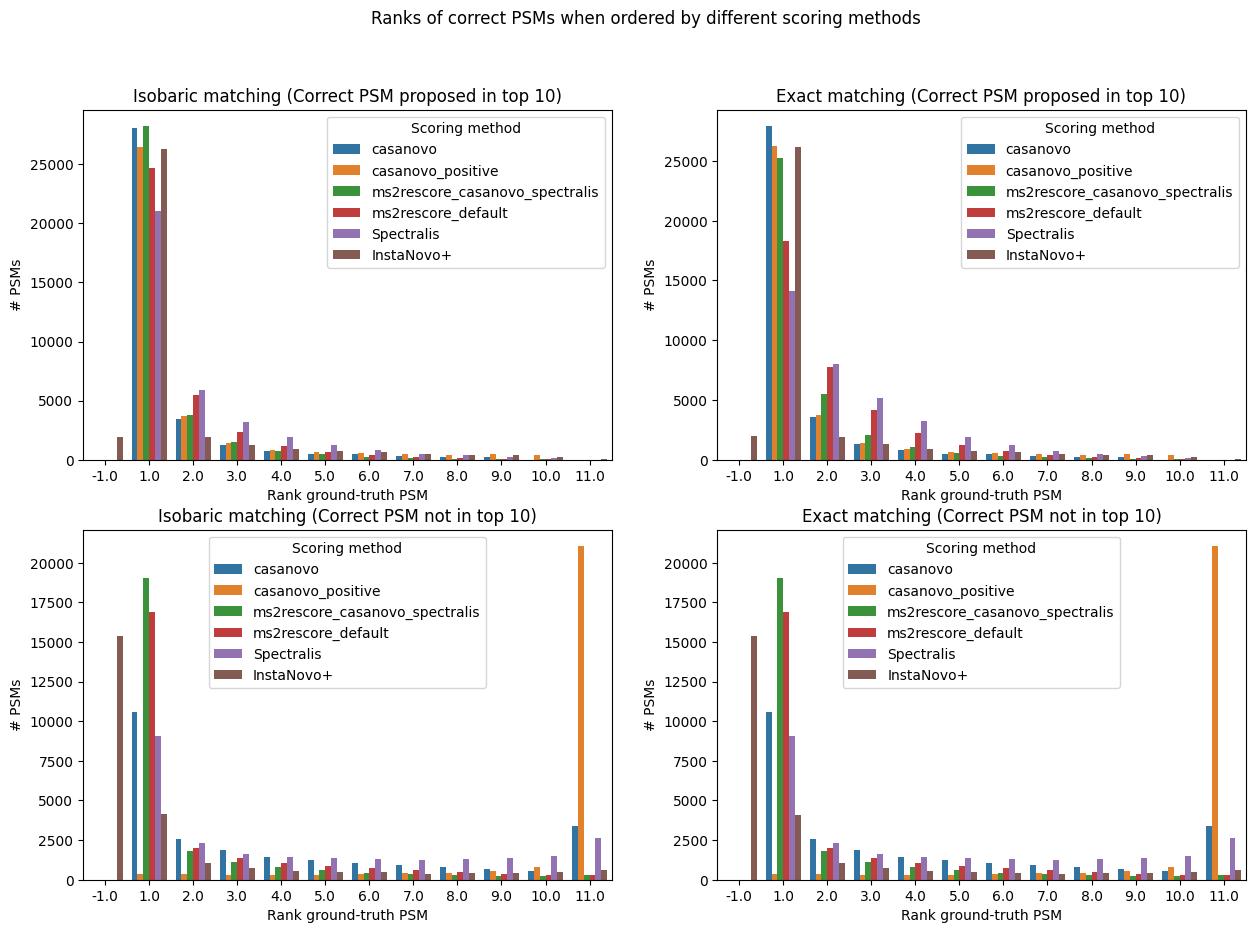

In [23]:
import seaborn as sns

fig, ax = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Ranks of correct PSMs when ordered by different scoring methods')

sns.barplot(
    rank_plot_df_isobaric.reset_index().melt(id_vars='index').rename(
        columns={
            'index': 'Rank ground-truth PSM',
            'variable': 'Scoring method',
            'value': "# PSMs",
        }
    ),
    x='Rank ground-truth PSM',
    y='# PSMs',
    hue='Scoring method',
    ax=ax[0,0]
)
sns.barplot(
    rank_plot_df_match.reset_index().melt(id_vars='index').rename(
        columns={
            'index': 'Rank ground-truth PSM',
            'variable': 'Scoring method',
            'value': "# PSMs",
        }
    ),
    x='Rank ground-truth PSM',
    y='# PSMs',
    hue='Scoring method',
    ax=ax[0,1]
)
sns.barplot(
    rank_plot_df_isobaric_false.reset_index().melt(id_vars='index').rename(
        columns={
            'index': 'Rank ground-truth PSM',
            'variable': 'Scoring method',
            'value': "# PSMs",
        }
    ),
    x='Rank ground-truth PSM',
    y='# PSMs',
    hue='Scoring method',
    ax=ax[1,0]
)
sns.barplot(
    rank_plot_df_match_false.reset_index().melt(id_vars='index').rename(
        columns={
            'index': 'Rank ground-truth PSM',
            'variable': 'Scoring method',
            'value': "# PSMs",
        }
    ),
    x='Rank ground-truth PSM',
    y='# PSMs',
    hue='Scoring method',
    ax=ax[1,1]
)

ax[0,0].set_title('Isobaric matching (Correct PSM proposed in top 10)')
ax[0,1].set_title('Exact matching (Correct PSM proposed in top 10)')
ax[1,0].set_title('Isobaric matching (Correct PSM not in top 10)')
ax[1,1].set_title('Exact matching (Correct PSM not in top 10)')

In [34]:
rank_plot_df_isobaric

,casanovo,casanovo_positive,ms2rescore_casanovo_spectralis,ms2rescore_default,Spectralis,InstaNovo+
-1.0,NaN,NaN,NaN,NaN,NaN,1937
1.0,28081.0,26427.0,28203.0,24645.0,21008.0,26279
2.0,3468.0,3688.0,3761.0,5478.0,5900.0,1892
3.0,1261.0,1407.0,1479.0,2357.0,3161.0,1277
4.0,779.0,851.0,755.0,1198.0,1913.0,905
5.0,501.0,613.0,443.0,692.0,1221.0,759
6.0,450.0,541.0,267.0,416.0,832.0,619
7.0,298.0,472.0,164.0,228.0,479.0,499
8.0,213.0,382.0,98.0,116.0,379.0,429
9.0,196.0,451.0,52.0,85.0,245.0,363


In [42]:
(rank_plot_df_isobaric.loc[1.0, 'casanovo']/rank_plot_df_isobaric-1)*100

,casanovo,casanovo_positive,ms2rescore_casanovo_spectralis,ms2rescore_default,Spectralis,InstaNovo+
-1.0,NaN,NaN,NaN,NaN,NaN,1349.716056
1.0,0.000000,6.258751,-0.432578,13.941976,33.668126,6.857186
2.0,709.717416,661.415401,646.636533,412.614093,375.949153,1384.196617
3.0,2126.883426,1895.806681,1798.647735,1091.387357,788.358115,2098.981989
4.0,3504.749679,3199.764982,3619.337748,2243.989983,1367.903816,3002.872928
5.0,5504.990020,4480.913540,6238.826185,3957.947977,2199.836200,3599.736495
6.0,6140.222222,5090.573013,10417.228464,6650.240385,3275.120192,4436.510501
7.0,9323.154362,5849.364407,17022.560976,12216.228070,5762.421712,5527.454910
8.0,13083.568075,7251.047120,28554.081633,24107.758621,7309.234828,6445.687646
9.0,14227.040816,6126.385809,53901.923077,32936.470588,11361.632653,7635.812672


In [47]:
rank_plot_df_isobaric_false

,casanovo,casanovo_positive,ms2rescore_casanovo_spectralis,ms2rescore_default,Spectralis,InstaNovo+
-1.0,NaN,NaN,NaN,NaN,NaN,15370
1.0,10561.0,378.0,19049.0,16900.0,9046.0,4122
2.0,2597.0,334.0,1826.0,1994.0,2310.0,1050
3.0,1860.0,285.0,1109.0,1395.0,1638.0,749
4.0,1409.0,304.0,780.0,1086.0,1440.0,552
5.0,1264.0,296.0,609.0,896.0,1388.0,484
6.0,1060.0,333.0,451.0,769.0,1302.0,456
7.0,942.0,400.0,336.0,590.0,1225.0,368
8.0,793.0,425.0,272.0,494.0,1282.0,410
9.0,679.0,537.0,215.0,376.0,1392.0,423


In [53]:
10561.0/len(false_spectrum_ids)

0.4202045119961803

In [54]:
(10561.0-378.0)/10561.0

0.964207934854654

In [ ]:
(28081.0/rank_plot_df_isobaric_false-1)*100

In [21]:
worst_to_best = rank_isobaric_df_false[
    (rank_isobaric_df_false['casanovo']==11) &
    (rank_isobaric_df_false['ms2rescore_default']==1)
]

In [22]:
run.get_spectrum(worst_to_best.index[1])

Spectrum ID: controllerType=0 controllerNumber=1 scan=84297
Ground-truth: <VW>LDPNETNEIANA<NS>R/2 ({'peptide': {'sage': 4.824482440948486, 'Spectralis': -0.6917120752264978, 'casanovo': 0.8084723353385925, 'ms2rescore_default': 4.852317612718183, 'ms2rescore_casanovo': 3.3493489563674363, 'ms2rescore_spectralis': 4.787404935407542, 'ms2rescore_casanovo_spectralis': 3.6480820176075626, 'score_ms2rescore': 4.824482440948486}, 'aa': {}})
Candidates:
	<VW>LDPNETQNTASQSPR/2 ({'peptide': {'casanovo': 0.9492881894111633, 'score_ms2rescore': 2.803846206534556, 'Spectralis': -0.8139215537909374, 'InstaNovo+': -0.6309886574745178, 'ms2rescore_default': 2.964358113957532, 'ms2rescore_casanovo': 2.959893986115336, 'ms2rescore_spectralis': 3.029876548385411, 'ms2rescore_casanovo_spectralis': 3.153197432087943}, 'aa': {'casanovo': (0.96, 0.967, 0.96867, 0.96542, 0.97057, 0.96934, 0.94702, 0.86394, 0.95721, 0.97027, 0.89742, 0.9131, 0.96948, 0.93511, 0.9673, 0.92654, 0.96918)}})
	WVLDPNETQNTASQSPR/2 

<Axes: xlabel='m/z', ylabel='Intensity'>

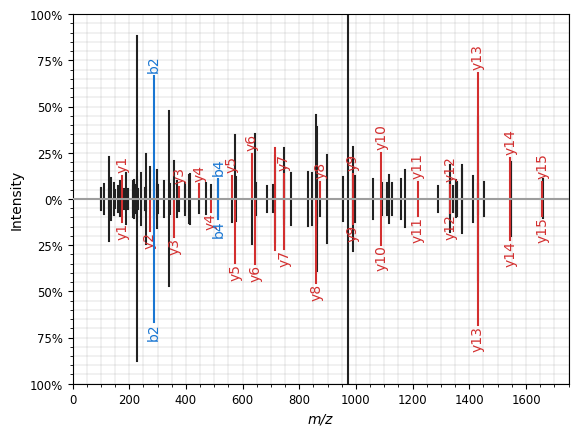

In [23]:
from denovo_utils.analysis.visualization import plot_spectrum
import spectrum_utils.plot as sup

specid = worst_to_best.index[1]

ms2resc = plot_spectrum(
    peak_path='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted/LFQ_Orbitrap_DDA_QC_01.mgf',
    spectrum_id=specid,
    peptide=str(run.get_spectrum(specid).psm_gt.peptidoform),
    peak_format='mgf',
    plot=False
)
cas = plot_spectrum(
    peak_path='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted/LFQ_Orbitrap_DDA_QC_01.mgf',
    spectrum_id=specid,
    peptide=str(run.get_spectrum(specid).psm_candidates[0].peptidoform),
    peak_format='mgf',
    plot=False
)
sup.mirror(
    ms2resc,
    cas
)

# Section 2

There are a couple of interesting aspect about the plots above:

0. Why is casanovo able to find the better candidate in some cases and not in top 10 of others?

- Plot score distributions for these (ms2rescore and casanovo)

1. Casanovo is better in ranking candidates, if they are found within the first 10 candidates.

Question: Why is MS2Rescore unable in this cases to distinguish ?

--> For the spectra which are scored better by casanovo, show the following:
- Score difference Casanovo
- Score difference ms2rescore
- Feature differences --> How to plot ?

2. Casanovo is not able to find a better target for some spectra

--> Why is ms2rescore able to find the correct one ?

- Score difference Casanovo
- Score difference MS2Rescore
- Feature differences

We need some code from notebooks in s2_error_types.

Port this into the codebase.

In [24]:
from denovo_utils.analysis.error_types import ChangeTracker
from psm_utils import Peptidoform
from Levenshtein import editops # To track actions for transpositions
from nltk import edit_distance # For Damerau–Levenshtein distance

from peak_pack.annotation.evidence import PeptideEvidence

In [424]:
MOD_MAPPER = {
    "[+25.980265]-": "b",
    "[Formula:H-2C1O1]-": 'b',
    "[UNIMOD:1]-": "a",
    "[UNIMOD:5]-": "d",
    "[UNIMOD:385]-": "e",
    "Q[UNIMOD:7]": "q",
    "N[UNIMOD:7]": "n",
    "C[UNIMOD:4]": "c",
    "M[UNIMOD:35]": 'm',
    "S[UNIMOD:21]": 's',
    "T[UNIMOD:21]": 't',
    "Y[UNIMOD:21]": 'y',
    "L": "I"
}

class SequenceComparison:
    def __init__(self, peptide_1: Peptidoform, peptide_2: Peptidoform, mod_mapper=MOD_MAPPER):
        self.tracker_1 = ChangeTracker()
        self.tracker_2 = ChangeTracker()
        self.mod_mapper = mod_mapper
        self.mod_mapper_reverse = {
            v: k for k, v in mod_mapper.items()
        }
        _ = self.mod_mapper_reverse.pop('I')
        self.fix = False
        self.peptidoform_1 = peptide_1 
        self.peptidoform_2 = peptide_2
        self.pepstring_1 = self._peptidoform_to_lstring(peptide_1, mod_mapper)
        self.pepstring_2 = self._peptidoform_to_lstring(peptide_2, mod_mapper)
        self.evidence_added = False
        self.distances = {}
        self.collection = {}
        self.annotations = []

    def __repr__(self):
        return f"{self.peptidoform_1.modified_sequence}\n" \
        f"{self.peptidoform_2.modified_sequence}\n" \
        f"{self.annotations}"

    def add_evidence(self, evidence_1: PeptideEvidence, evidence_2: PeptideEvidence):
        """Add peptide evidence."""
        self.pe_1 = evidence_1
        self.pe_2 = evidence_2

    def calculate_distance(self):
        """Calculate the (Damerau-)Levenshtein distance. Required before annotating differences."""
        self.distances['damerau-levenshtein'] = edit_distance(
            s1=self.pepstring_1,
            s2=self.pepstring_2,
            transpositions=True
        )
        self.changes_peptide_2 = editops(
            self.pepstring_1,
            self.pepstring_2
        )
        self.changes_peptide_1 = editops(
            self.pepstring_2,
            self.pepstring_1
        )
        self.distances['levenshtein'] = len(self.changes_peptide_2)
        self.distances['mass'] = self.peptidoform_1.theoretical_mass-self.peptidoform_2.theoretical_mass

    def _check_equivalence(self, c1, c2):
        """
        Check if source and target are always the same.
        
        If not, find a way to fix it.

        This only fixes the comparison when the two changes
        are split up in two in both collections.

        I have no idea how to parse this otherwise. This
        parsing thing is already so damn complex.
        """
        fix = False
        prev_indices_1 = [-10]
        prev_indices_2 = [-10]

        new_changes_1 = []
        new_changes_2 = []

        for change_1, change_2 in zip(c1, c2):
            added_new = False
                
            # Check if we can couple the changes
            if (change_1['indices'][0]-2==prev_indices_1[-1]) and (change_2['indices'][0]-2==prev_indices_2[-1]):
                # Check for equivalency
                i1 = change_1['indices'][0]-1
                i2 = change_2['indices'][0]-1
            
                new_source_1 = prev_change_1['source'] + self.pepstring_2[i1] + change_1['source']
                new_target_1 = prev_change_1['target'] + self.pepstring_2[i1] + change_1['target']

                new_source_2 = prev_change_2['source'] + self.pepstring_1[i2] + change_2['source']
                new_target_2 = prev_change_2['target'] + self.pepstring_1[i2] + change_2['target']
            
                if (new_source_1==new_target_2) and (new_target_1==new_source_2):
                    new_change_1 = {
                        'target': new_target_1,
                        'source': new_source_1,
                        'indices': prev_indices_1 + [i1] + change_1['indices']
                    }
                    new_change_2 = {
                        'target': new_target_2,
                        'source': new_source_2,
                        'indices': prev_indices_2 + [i2] + change_2['indices']
                    }
                    added_new = True
                    fix = True
                    new_changes_1 = new_changes_1[:-1] + [new_change_1]
                    new_changes_2 = new_changes_2[:-1] + [new_change_2]

            if not added_new:
                new_changes_1.append(change_1)
                new_changes_2.append(change_2)

            prev_indices_1 = change_1['indices']
            prev_indices_2 = change_2['indices']
            prev_change_1 = change_1
            prev_change_2 = change_2

        self.fix = fix
        return new_changes_1, new_changes_2

    def annotate_swaps(self, with_evidence=False):
        """
        Parse the differences between the two sites in an easily readible fashion.
        
        Also evaluates whether the differences are ambiguous if with_evidence is True.
        """
        assert len(self.distances) == 3
        collection_1 = self.tracker_1.track_changes(
            s1=self.pepstring_1,
            s2=self.pepstring_2,
            actions=self.changes_peptide_2
        )        
        collection_2 = self.tracker_2.track_changes(
            s1=self.pepstring_2,
            s2=self.pepstring_1,
            actions=self.changes_peptide_1
        )
        collection_1, collection_2 = self._check_equivalence(
            collection_1, collection_2
        )
        self.tracker_1.collection = collection_1
        self.tracker_2.collection = collection_2

        if with_evidence:
            collection_1 = self.tracker_1.add_locations(
                peptide_evidence=self.pe_2
            )
            collection_2 = self.tracker_2.add_locations(
                peptide_evidence=self.pe_1
            )
        
        # Sometimes, this is not symmetric...
        # If not symmetric, ambiguity cannot be defined
        self.collection['peptide_2'] = collection_1
        self.collection['peptide_1'] = collection_2
        symmetric = self._distance_is_symetric(c1=collection_1, c2=collection_2)
        self.symmetry = symmetric
        if symmetric:
            if with_evidence:
                self._infer_ambiguity()

        self.annotations = []
        for change in collection_1:
            target = self._peptidoform_to_lstring(change['target'], self.mod_mapper_reverse)
            source = self._peptidoform_to_lstring(change['source'], self.mod_mapper_reverse)
            if with_evidence and symmetric:
                self.annotations.append(
                    (f'{source} -> {target}', change['ambiguous'])
                )
            else:
                self.annotations.append(
                    (f'{source} -> {target}', None)
                )

            md = self._get_mass_tag(target) - self._get_mass_tag(source)
            change['mass_difference'] = md

        self.sites = len(self.annotations)

    def _get_mass_tag(self, tag):
        if tag == '':
            return 0
        elif tag.endswith('-'):
            return Peptidoform(tag+'G/2').theoretical_mass-Peptidoform('G/2').theoretical_mass
        else:
            return Peptidoform(tag+"/2").theoretical_mass

    def _distance_is_symetric(self, c1, c2):
        if len(c1) != len(c2):
            # print(f"WARNING!\n{c1}\n{c2}")
            return False
        
        for (i1, i2) in zip(c1, c2):
            if i1['target'] != i2['source']:
                # print(f"WARNING!\n{c1}\n{c2}")
                return False
        return True

    def _peptidoform_to_lstring(self, peptidoform: Peptidoform, mapper: dict):
        """Parse peptidoforms so modifications are encoded by a single token. (depends on mapper)"""
        if isinstance(peptidoform, Peptidoform):
            new_peptidoform = peptidoform.proforma
        else:
            new_peptidoform = peptidoform
        for p, l in mapper.items():
            new_peptidoform = new_peptidoform.replace(p, l)
        return new_peptidoform.split('/')[0]
    
    def _infer_ambiguity(self):
        """Evaluate whether the differing sites are ambiguous between the two sequences."""
        for (swap_1, swap_2) in zip(self.collection['peptide_2'], self.collection['peptide_1']):
            # If both are fully annotated or both have no annotations
            if swap_1['annotation']==swap_2['annotation']:
                swap_1['ambiguous'] = True
                swap_2['ambiguous'] = True
            else:
                swap_1['ambiguous'] = False
                swap_2['ambiguous'] = False


In [423]:
class ChangeTracker:
    def __init__(self):
        self.change_s1 = ''
        self.change_s2 = ''
        self.collection = []
        self.indices = []
        self.prev_action = None
    

    def collect_change(self):
        '''Collect an entry.'''
        self.collection.append(
            {
                'target': self.change_s1,
                'source': self.change_s2,
                'indices': self.indices
            }
        )
        self.flush()
    
    def flush(self):
        '''Clear the tracker.'''
        self.change_s1 = ''
        self.change_s2 = ''
        self.indices = []
        self.prev_action = None

    def track_changes(self, s1, s2, actions):
        self.collection = []

        deleted = 0
        prev_index = 0
        flag_start = True

        for (action, idx_s1, idx_s2) in actions:

            # New site of change
            if action == 'delete':
                deleted += 1
            idx_s2_deletion = idx_s2 - deleted

            if idx_s2_deletion - prev_index > 1 and not flag_start:
                # If multiple deletes after each other
                if len(self.indices)>0 and (self.indices[-1]==idx_s2):
                    pass
                else:
                    self.collect_change()

            if action == 'insert':
                # change_s1 += s1[idx_s1]
                self.change_s2 += s2[idx_s2]      

            elif action == 'replace':
                # Fixes weird bug where it does not detect new site
                if self.prev_action == 'delete':
                    self.collect_change()

                self.change_s1 += s1[idx_s1]
                self.change_s2 += s2[idx_s2]
            elif action == 'delete':
                # Transposition
                if self.prev_action == 'insert':
                    # print(idx_s1, idx_s2, idx_s2_deletion, deleted)
                    self.change_s1 += s1[idx_s1-1]
                    self.change_s2 += s2[idx_s2-1]
                    self.change_s1 += s1[idx_s1]
                
                elif self.prev_action == 'replace':
                    # print(idx_s1, idx_s2, idx_s2_deletion, prev_index, self.indices)
                    if self.indices[-1]+1 != idx_s2:
                        self.collect_change()
                    self.change_s1 += s1[idx_s1]

                elif self.prev_action == 'delete' and not (self.indices[-1]==idx_s2):
                    self.collect_change()
                    self.change_s1 += s1[idx_s1]

                else:
                    self.change_s1 += s1[idx_s1]
                # change_s2 += s2[idx_s2-deleted]
            
            if action == 'delete' and self.prev_action == 'insert':  
                self.indices.append(idx_s2-1)
            else:
                self.indices.append(idx_s2)

            prev_index = idx_s2_deletion
            self.prev_action = action
            flag_start = False

        self.collect_change()
        return self.collection

    def add_locations(self, peptide_evidence):
        # get ambiguous sites
        ambiguous_indices = []
        ambiguous_tags = peptide_evidence.get_ambiguous_tag_idx()
        for idx_1, idx_2 in ambiguous_tags:
            ambiguous_indices += list(range(idx_1, idx_2+1))
        
        for change in self.collection:
            ambiguous_site = True # True if all fragment ions are missing
            all_annotated = True # True if all fragment ions are present
            for idx in change['indices']:
                if idx not in ambiguous_indices:
                    ambiguous_site = False
                if idx in ambiguous_indices:
                    all_annotated = False

            # If all fragments are annotated
            if all_annotated:
                change['annotation'] = 'complete'
            elif ambiguous_site:
                change['annotation'] = 'absent'
            else:
                change['annotation'] = 'partly'
            

            change['n_term'] = change['indices'][0]
            change['c_term'] = len(peptide_evidence.peptidoform) - change['indices'][-1] - 1
        
        return self.collection

## 0. Casanovo and MS2Rescore score distributions

In [25]:
from denovo_utils.analysis.error_types import SequenceComparison

In [26]:
non_symmetric = []
def row_seq_comparison(row):
    try:
        sc = SequenceComparison(
            peptide_1=row['PE_casanovo'].peptidoform,
            peptide_2=row['PE_ms2rescore'].peptidoform
        )
        sc.add_evidence(
            evidence_1=row['PE_casanovo'],
            evidence_2=row['PE_ms2rescore']
        )
        sc.calculate_distance()
        sc.annotate_swaps(with_evidence=True)
        if not sc.symmetry:
            non_symmetric.append(row.name)
        return sc
    except:
        
        raise Exception(row)

<Axes: >

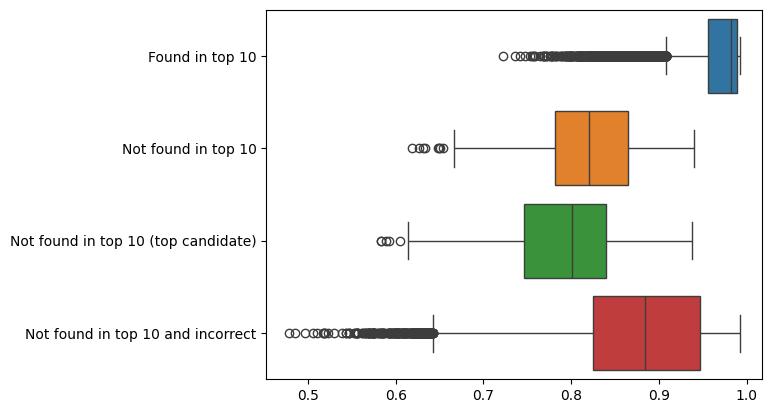

In [889]:
# Scores of correct peptide but not in top 10
scores_not_found = []
scores_not_found_best_candidate = []
scores_found = []
best_score_not_found_and_incorrect = []

for specid in rank_isobaric_df_false[
    (rank_isobaric_df_false['casanovo_positive']==1)
].index:
    scores_not_found.append(run.get_spectrum(specid).psm_gt.scores.get_score('casanovo_positive'))
    scores_not_found_best_candidate.append(
        max(
            [i.scores.get_score('casanovo_positive') for i in run.get_spectrum(specid).psm_candidates]
        )
    )

for specid in rank_isobaric_df_false[
    (rank_isobaric_df_false['casanovo_positive']!=1)
].index:
    best_score_not_found_and_incorrect.append(
        max(
            [i.scores.get_score('casanovo_positive') for i in run.get_spectrum(specid).psm_candidates]
        )
    )


for specid in rank_isobaric_df[
    (rank_isobaric_df['casanovo_positive']==1)
].index:
    scores_found.append(run.get_spectrum(specid).psm_gt.scores.get_score('casanovo_positive'))

sns.boxplot(
    {
        'Found in top 10': scores_found,
        'Not found in top 10': scores_not_found,
        'Not found in top 10 (top candidate)': scores_not_found_best_candidate,
        'Not found in top 10 and incorrect': best_score_not_found_and_incorrect
    },
    orient='h'
)

<Axes: >

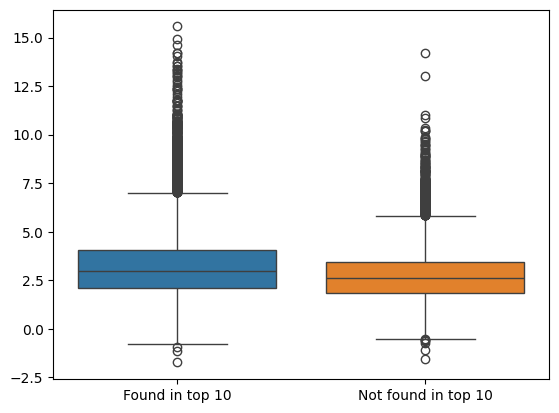

In [ ]:
# Scores of correct peptide but not in top 10
scores_not_found = []
scores_found = []

for specid in rank_isobaric_df_false[
    (rank_isobaric_df_false['ms2rescore_default']==1)
].index:
    scores_not_found.append(run.get_spectrum(specid).psm_gt.scores.get_score('ms2rescore_default'))


for specid in rank_isobaric_df[
    (rank_isobaric_df['ms2rescore_default']==1)
].index:
    scores_found.append(run.get_spectrum(specid).psm_gt.scores.get_score('ms2rescore_default'))

sns.boxplot(
    {
        'Found in top 10': scores_found,
        'Not found in top 10': scores_not_found
    }
)

## 1. Why can Casanovo better rank candidates ?

In [55]:
better_casanovo_specids = rank_isobaric_df[
    (rank_isobaric_df['casanovo_positive']==1) &
    (rank_isobaric_df['ms2rescore_default']!=1)
].index
len(better_casanovo_specids)

6887

### Score differences

In [56]:
import numpy as np

gt_casanovo_positive_best = {}
gt_ms2rescore_best = {}

fr_casanovo_positive_best = {}
fr_ms2rescore_best = {}

pe_gt_dict = {}
pe_ms2rescore_dict = {}

for specid in better_casanovo_specids:
    spectrum = run.get_spectrum(specid)
    gt_casanovo_positive = [spectrum.psm_gt.scores.get_score('casanovo_positive')]
    gt_ms2rescore = [spectrum.psm_gt.scores.get_score('ms2rescore_default')]

    peptidoform_gt = [spectrum.psm_gt.peptide_evidence]
    peptidoform_ms2rescore = []

    fr_casanovo_positive = []
    fr_ms2rescore = []

    found=False

    for psm in spectrum.psm_candidates:
        if psm.metadata['rank_ms2rescore_default'] == 1:
            fr_ms2rescore.append(psm.scores.get_score('ms2rescore_default'))
            fr_casanovo_positive.append(psm.scores.get_score('casanovo_positive'))
            peptidoform_ms2rescore.append(psm.peptide_evidence)
            found=True

        if psm.metadata['rank_casanovo_positive'] == 1:
            gt_casanovo_positive.append(psm.scores.get_score('casanovo_positive'))
            gt_ms2rescore.append(psm.scores.get_score('ms2rescore_default'))
            peptidoform_gt.append(psm.peptide_evidence)

    if not found:
        raise Exception()
    

    gt_casanovo_positive_best[specid] = max(gt_casanovo_positive)
    gt_ms2rescore_best[specid] = max(gt_ms2rescore)

    fr_casanovo_positive_best[specid] = max(fr_casanovo_positive)
    fr_ms2rescore_best[specid] = max(fr_ms2rescore)

    pe_gt_dict[specid] = peptidoform_gt[np.argmax(gt_casanovo_positive)]
    pe_ms2rescore_dict[specid] = peptidoform_ms2rescore[np.argmax(fr_ms2rescore)]

In [57]:
score_differences = pd.DataFrame(
    [
        gt_casanovo_positive_best,
        gt_ms2rescore_best,
        fr_casanovo_positive_best,
        fr_ms2rescore_best,
        pe_gt_dict,
        pe_ms2rescore_dict
    ]
).T.rename(
    columns={
        0: 'gt_casanovo',
        1: 'gt_ms2rescore',
        2: 'fr_casanovo',
        3: 'fr_ms2rescore',
        4: 'PE_casanovo',
        5: 'PE_ms2rescore'
    }
)

In [58]:
score_differences['casanovo_diff'] = score_differences.apply(lambda x: x['gt_casanovo']-x['fr_casanovo'], axis=1)
score_differences['ms2rescore_diff'] = score_differences.apply(lambda x: x['gt_ms2rescore']-x['fr_ms2rescore'], axis=1)

<Axes: xlabel='ms2rescore_diff'>

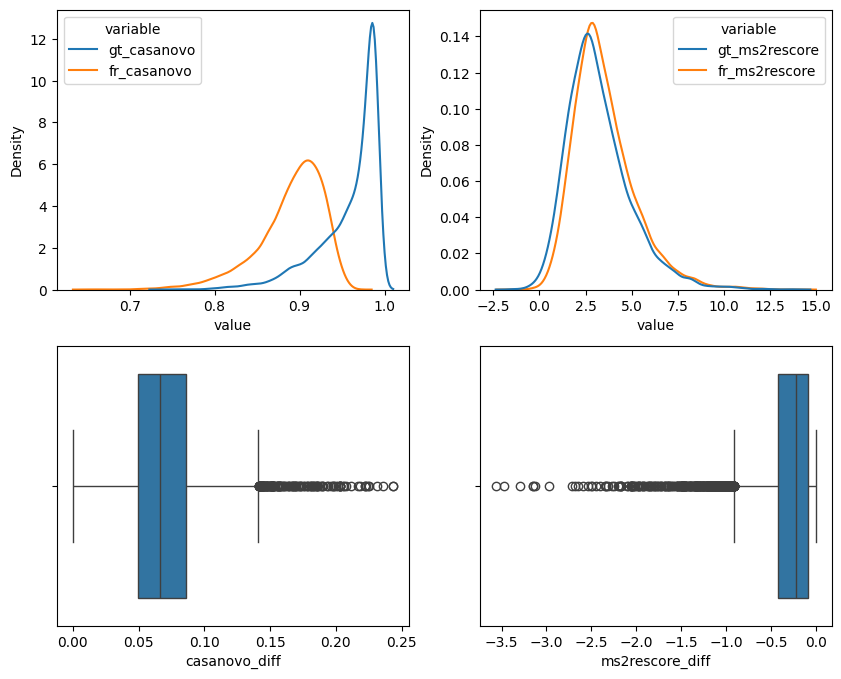

In [59]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
sns.kdeplot(
    score_differences[['gt_casanovo', 'fr_casanovo']][score_differences['fr_casanovo']>0].melt(),
    x='value',
    hue='variable',
    ax=ax[0,0]
)
sns.kdeplot(
    score_differences[['gt_ms2rescore', 'fr_ms2rescore']].melt(),
    x='value',
    hue='variable',
    ax=ax[0,1]
)

sns.boxplot(
    score_differences[score_differences['fr_casanovo']>0],
    x='casanovo_diff',
    ax=ax[1,0]
)
sns.boxplot(
    score_differences,
    x='ms2rescore_diff',
    ax=ax[1,1]
)

### Distances and error types for unresolvable ms2rescore

In [60]:
peptide_columns = ['PE_casanovo', 'PE_ms2rescore', 'swaps', 'changes']

In [61]:
score_differences.columns

Index(['gt_casanovo', 'gt_ms2rescore', 'fr_casanovo', 'fr_ms2rescore',
       'PE_casanovo', 'PE_ms2rescore', 'casanovo_diff', 'ms2rescore_diff'],
      dtype='object')

In [62]:
non_symmetric = []
def row_seq_comparison(row):
    try:
        sc = SequenceComparison(
            peptide_1=row['PE_casanovo'].peptidoform,
            peptide_2=row['PE_ms2rescore'].peptidoform
        )
        sc.add_evidence(
            evidence_1=row['PE_casanovo'],
            evidence_2=row['PE_ms2rescore']
        )
        sc.calculate_distance()
        sc.annotate_swaps(with_evidence=True)
        if not sc.symmetry:
            non_symmetric.append(row.name)
        return sc
    except:
        
        raise Exception(row)

score_differences['sequence_comparison'] = score_differences.apply(row_seq_comparison, axis=1)

In [63]:
score_differences['levenshtein'] = score_differences.apply(lambda x: x['sequence_comparison'].distances['levenshtein'], axis=1)
score_differences['damerau-levenshtein'] = score_differences.apply(lambda x: x['sequence_comparison'].distances['damerau-levenshtein'], axis=1)
score_differences['n_sites'] = score_differences.apply(lambda x: x['sequence_comparison'].sites, axis=1)

score_differences['DL-norm'] = score_differences.apply(
    lambda x: x['damerau-levenshtein']/max(
        len(x['PE_ms2rescore'].peptidoform),
        len(x['PE_casanovo'].peptidoform)
    ),
    axis=1
)

<Axes: xlabel='DL-norm', ylabel='Density'>

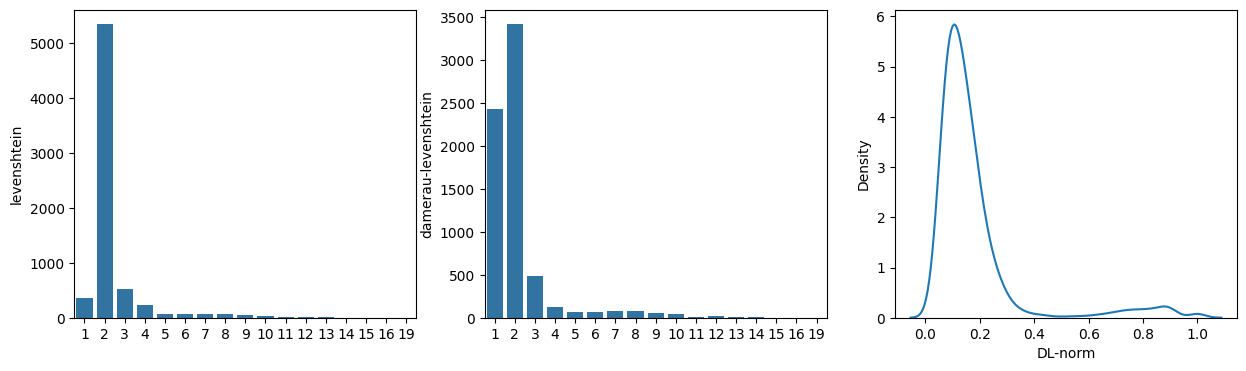

In [64]:
fig, ax = plt.subplots(1,3,figsize=(15,4))

sns.barplot(
    score_differences['levenshtein'].value_counts(),
    ax=ax[0]
)
sns.barplot(
    score_differences['damerau-levenshtein'].value_counts(),
    ax=ax[1]
)
sns.kdeplot(
    score_differences['DL-norm'],
    ax=ax[2]
)

In [67]:
score_differences['damerau-levenshtein'].value_counts(normalize=True).sort_index().cumsum()

1     0.353565
2     0.849572
3     0.920720
4     0.938870
5     0.947728
6     0.957311
7     0.968346
8     0.979091
9     0.986496
10    0.992595
11    0.994628
12    0.996951
13    0.998693
14    0.999274
15    0.999564
16    0.999855
19    1.000000
Name: damerau-levenshtein, dtype: float64

<Axes: >

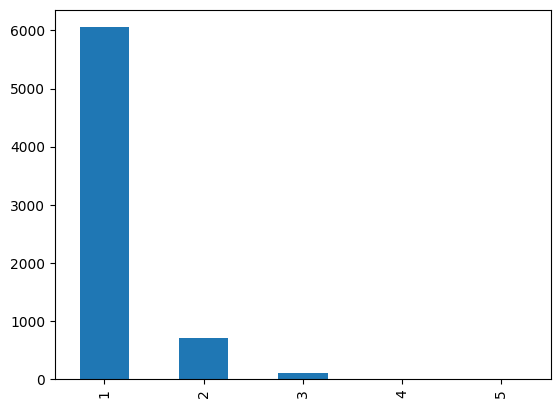

In [902]:
score_differences['n_sites'].value_counts().plot(kind='bar')

In [68]:
selection = score_differences[score_differences['sequence_comparison'].apply(lambda x: x.symmetry)]

In [69]:
selection['sequence_comparison'].apply(lambda x: all([tag['ambiguous'] for tag in x.collection['peptide_2']])).value_counts(normalize=True)

True     0.647763
False    0.352237
Name: sequence_comparison, dtype: float64

In [905]:
def add_swap_to_dict(d, swap, sc: SequenceComparison, swap_dicts=None, ordering_matters=False):
    aas_1 = sc._peptidoform_to_lstring(swap[0], mapper=sc.mod_mapper_reverse)
    aas_2 = sc._peptidoform_to_lstring(swap[1], mapper=sc.mod_mapper_reverse)
    if not ordering_matters:

        aas_1 = ''
        aas_2 = ''
        # Create new tags but in the same order.
        # This way, the set is always the same
        # The ordering is alphabetic on amino acids.
        for aa_1 in sorted(swap_dicts[0].keys(), key=lambda s: (s.isupper(), s.lower())):
            aas_1 += aa_1*swap_dicts[0][aa_1]
        for aa_2 in sorted(swap_dicts[1].keys(), key=lambda s: (s.isupper(), s.lower())):
            aas_2 += aa_2*swap_dicts[1][aa_2]

        aas_1 = sc._peptidoform_to_lstring(aas_1, mapper=sc.mod_mapper_reverse)
        aas_2 = sc._peptidoform_to_lstring(aas_2, mapper=sc.mod_mapper_reverse)

    set_swap = ' <-> '.join(set([aas_1, aas_2]))
    
    if set_swap in d.keys():
        d[set_swap][0] += 1
    else:
        d[set_swap] = [1]

def check_same_aas(swap):
    dict_1 = {}
    dict_2 = {}

    for aa in swap[0]:
        if aa in dict_1.keys():
            dict_1[aa] += 1
        else:
            dict_1[aa] = 1
    
    for aa in swap[1]:
        if aa in dict_2.keys():
            dict_2[aa] += 1
        else:
            dict_2[aa] = 1
    return (dict_1, dict_2), dict_1 == dict_2

variations = {
    'reordering': {},
    'isobaric_alternative': {},
    'alternative': {}
}
md_alternatives = []

for sc in selection['sequence_comparison'].tolist():
    
    if sc.sites == 1:
        swap_ = sc.annotations[0][0].split(' -> ')
        swap = swap_.copy()
        swap[0] = sc._peptidoform_to_lstring(swap[0], mapper=sc.mod_mapper)
        swap[1] = sc._peptidoform_to_lstring(swap[1], mapper=sc.mod_mapper)

        (dict_1, dict_2), same_composition = check_same_aas(swap)

        md = np.round(
            abs(Peptidoform(swap_[0]).theoretical_mass - Peptidoform(swap_[1]).theoretical_mass),
            4
        )
        

        # Reordering:
        if same_composition:
            add_swap_to_dict(variations['reordering'], swap, ordering_matters=True, sc=sc)

        # Isobaric
        elif md<.001:
            add_swap_to_dict(
                variations['isobaric_alternative'],
                swap,
                swap_dicts=[dict_1,dict_2],
                ordering_matters=False,
                sc=sc
            )

        else:
            add_swap_to_dict(variations['alternative'], swap, ordering_matters=True, sc=sc)
            md_alternatives.append(md)

In [906]:
counts = {
    'reorderings': [pd.DataFrame(variations['reordering']).T.sum()[0]],
    'isobaric alternatives': [pd.DataFrame(variations['isobaric_alternative']).T.sum()[0]],
    'Other': [pd.DataFrame(variations['alternative']).T.sum()[0]]
}
pd.DataFrame(counts).T/pd.DataFrame(counts).T.sum()

,0
reorderings,0.367436
isobaric alternatives,0.527389
Other,0.105174


<Axes: xlabel='Count', ylabel='Reordering'>

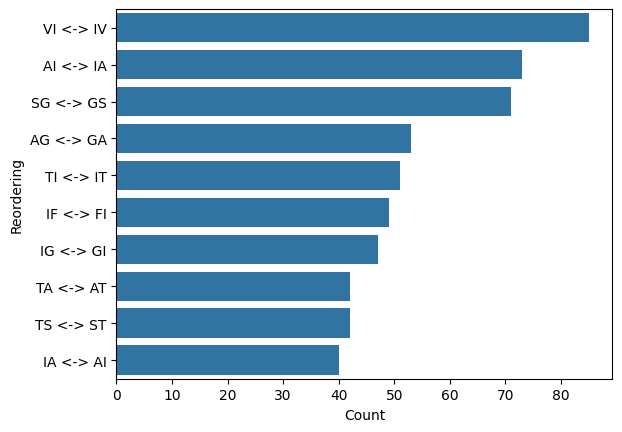

In [907]:
sns.barplot(
    pd.DataFrame(
        variations['reordering']
    ).T.sort_values(by=0, ascending=False).head(10).reset_index().rename(
        columns={0: 'Count', 'index': 'Reordering'}
    ),
    x='Count',
    y='Reordering'
)

In [908]:
pd.DataFrame(variations['isobaric_alternative']).T.sort_values(by=0, ascending=False).head(10).rename(columns={0: 'Same AA\'s'})

,Same AA's
GG <-> N,684
AG <-> Q,546
E <-> [UNIMOD:1]-S,267
AS <-> GT,149
EG <-> AD,107
[UNIMOD:5]-A <-> N,100
AV <-> GI,99
IS <-> TV,95
DT <-> ES,83
AN <-> GQ,71


<Axes: xlabel='Count', ylabel='Isobaric change'>

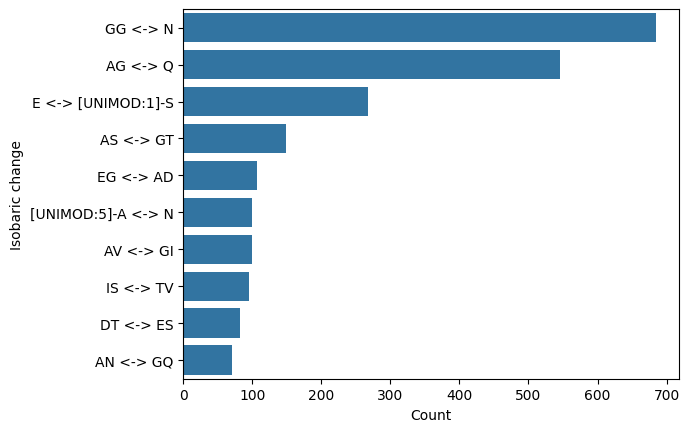

In [909]:
sns.barplot(
    pd.DataFrame(
        variations['isobaric_alternative']
    ).T.sort_values(by=0, ascending=False).head(10).reset_index().rename(
        columns={0: 'Count', 'index': 'Isobaric change'}
    ),
    x='Count',
    y='Isobaric change'
)

<Axes: xlabel='Count', ylabel='Other errors'>

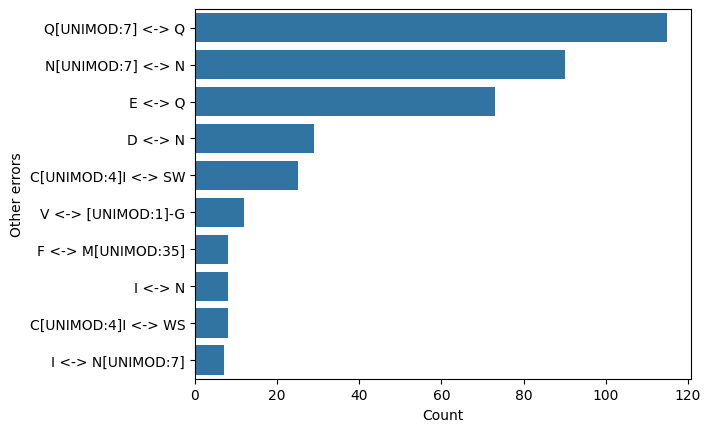

In [910]:
sns.barplot(
    pd.DataFrame(
        variations['alternative']
    ).T.sort_values(by=0, ascending=False).head(10).reset_index().rename(
        columns={0: 'Count', 'index': 'Other errors'}
    ),
    x='Count',
    y='Other errors'
)

In [22]:
from psm_utils import Peptidoform

Peptidoform('C[UNIMOD:4]I').theoretical_mass - Peptidoform('WS').theoretical_mass

0.0033714077100057693

In [911]:
mds=pd.Series(md_alternatives)

In [912]:
((mds<.99) & (mds>.98)).value_counts(normalize=True)

True     0.536859
False    0.463141
dtype: float64

In [913]:
((mds>1.0) & (mds<1.1)).value_counts(normalize=True)

False    0.961538
True     0.038462
dtype: float64

In [914]:
((mds<.01)).value_counts(normalize=True)

False    0.871795
True     0.128205
dtype: float64

Seems like casanovo is pretty sure it can distinguish these cases. Which is surprising to me.

### Feature differences

## 2. Why does Casanovo fail to find a nice hit for some spectra eventhough it would score it highest, i.e. why does beam search fail

Compare scores again for the following:
1. Casanovo scores for correct (in and not in top candidates)
2. MS2Rescore scores for same two sets (in and not in top candidates)

For these hits (in and not in top candidates but predicted correctly), check differences in distribution of several interesting features as discussed later in error_spectrum.

- cos
- rt diff
- hyperscore
- missing frag sites (pct)
- ppm_precursor
- Maybe the distance to a site with peaks (distance from C or N terminus for the ambiguous cases)

Reason why I compare them here, is so I can see why casanovo is so unconfident in these.

### Score comparison

In [925]:
correct_casanovo_in_top_10 = rank_isobaric_df[
    (rank_isobaric_df['casanovo_positive']==1) &
    (rank_isobaric_df['ms2rescore_default']==1)
].index.tolist()
correct_casanovo_not_in_top_10 = rank_isobaric_df_false[
    (rank_isobaric_df_false['casanovo_positive']==1) &
    (rank_isobaric_df_false['ms2rescore_default']==1)
].index.tolist()

In [918]:
scores = {
    'casanovo_positive': [],
    'casanovo_positive_second_rank': [],
    'ms2rescore': [],
    'ms2rescore_second_rank': [],
    'in_top_10': []
}

for specid in correct_casanovo_in_top_10:
    psms = [run.get_spectrum(specid).psm_gt] + run.get_spectrum(specid).psm_candidates
    casanovo_positive_scores = []
    casanovo_positive_scores_second_rank = []
    ms2rescore_scores = []
    ms2rescore_scores_second_rank = []
    for psm in psms:
        if psm.metadata['rank_casanovo_positive'] == 1:
            casanovo_positive_scores.append(psm.scores.get_score(metadata='casanovo_positive'))
            ms2rescore_scores.append(psm.scores.get_score(metadata='ms2rescore_default'))
        if psm.metadata['rank_casanovo_positive'] == 2:
            casanovo_positive_scores_second_rank.append(psm.scores.get_score(metadata='casanovo_positive'))
            ms2rescore_scores_second_rank.append(psm.scores.get_score(metadata='ms2rescore_default'))

    scores['casanovo_positive'].append(max(casanovo_positive_scores))
    scores['ms2rescore'].append(max(ms2rescore_scores))

    try:
        scores['casanovo_positive_second_rank'].append(max(casanovo_positive_scores_second_rank))
        scores['ms2rescore_second_rank'].append(max(ms2rescore_scores_second_rank))
    except:
        scores['casanovo_positive_second_rank'].append(np.nan)
        scores['ms2rescore_second_rank'].append(np.nan)
    scores['in_top_10'].append(True)

for specid in correct_casanovo_not_in_top_10:
    psms = [run.get_spectrum(specid).psm_gt] + run.get_spectrum(specid).psm_candidates
    casanovo_positive_scores = []
    casanovo_positive_scores_second_rank = []
    ms2rescore_scores = []
    ms2rescore_scores_second_rank = []
    for psm in psms:
        if psm.metadata['rank_casanovo_positive'] == 1:
            casanovo_positive_scores.append(psm.scores.get_score(metadata='casanovo_positive'))
            ms2rescore_scores.append(psm.scores.get_score(metadata='ms2rescore_default'))
        if psm.metadata['rank_casanovo_positive'] == 2:
            casanovo_positive_scores_second_rank.append(psm.scores.get_score(metadata='casanovo_positive'))
            ms2rescore_scores_second_rank.append(psm.scores.get_score(metadata='ms2rescore_default'))

    scores['casanovo_positive'].append(max(casanovo_positive_scores))
    scores['ms2rescore'].append(max(ms2rescore_scores))
    try:
        scores['casanovo_positive_second_rank'].append(max(casanovo_positive_scores_second_rank))
        scores['ms2rescore_second_rank'].append(max(ms2rescore_scores_second_rank))
    except:
        scores['casanovo_positive_second_rank'].append(np.nan)
        scores['ms2rescore_second_rank'].append(np.nan)
    scores['in_top_10'].append(False)

scores_df = pd.DataFrame(scores)

In [833]:
scores_df['casanovo_second_rank_positive'] = scores_df.casanovo_second_rank.apply(
    lambda x: x if x>0 else 1+x
)

<Axes: xlabel='ms2rescore'>

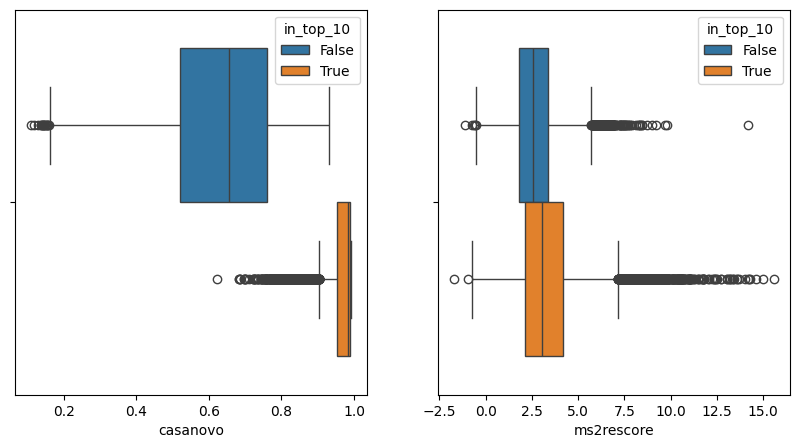

In [834]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.boxplot(
    scores_df,
    x='casanovo',
    hue='in_top_10',
    ax=ax[0]
)

sns.boxplot(
    scores_df,
    x='ms2rescore',
    hue='in_top_10',
    ax=ax[1]
)

In [921]:
scores_df.shape

(19867, 5)

In [879]:
# Only include those that were also ranked first by ms2rescore (union)
(scores_df[~scores_df['in_top_10']].apply(
    lambda x: x['casanovo_second_rank_positive']-x['casanovo'],
    axis=1
)>0).value_counts(normalize=True)

True     0.905249
False    0.094751
dtype: float64

In [755]:
(scores_df[~scores_df['in_top_10']].apply(
    lambda x: x['casanovo_second_rank_positive']-x['casanovo'],
    axis=1
)>0).value_counts(normalize=True)

True     0.922735
False    0.077265
dtype: float64

In 92% of the cases when casanovo ranks a hit correctly, this is due to applying the mass filter.

In [836]:
scores_df['casanovo_diff'] = scores_df.apply(
    lambda x: x['casanovo'] - x['casanovo_second_rank_positive'], 
    axis=1
)
scores_df['ms2rescore_diff'] = scores_df.apply(
    lambda x: min(x['ms2rescore'] - x['ms2rescore_second_rank'], 20), 
    axis=1
)

<Axes: xlabel='ms2rescore_diff'>

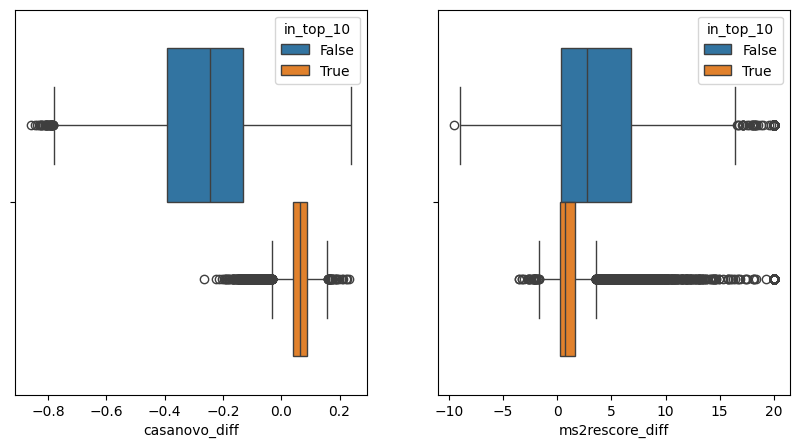

In [767]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.boxplot(
    scores_df,
    x='casanovo_diff',
    hue='in_top_10',
    ax=ax[0]
)

sns.boxplot(
    scores_df,
    x='ms2rescore_diff',
    hue='in_top_10',
    ax=ax[1]
)

### Feature differences

In [838]:
features_gt = pd.read_parquet('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/ground_truth.parquet')

In [839]:
features_of_interest = [
    'rt_diff',
    'hyperscore',
    'cos',
    'tic',
    'explained_all_pct',
    'missing_frag_sites',
    'missing_frag_count',
    'missing_frag_pct',
    'ppm_precursor'
]

In [926]:
features_in_top_10 = pd.DataFrame(
    features_gt.set_index('spectrum_id').loc[correct_casanovo_in_top_10]['rescoring_features'].tolist()
)[features_of_interest]
features_in_top_10['in_top_10'] = True

features_not_in_top_10 = pd.DataFrame(
    features_gt.set_index('spectrum_id').loc[correct_casanovo_not_in_top_10]['rescoring_features'].tolist()
)[features_of_interest]
features_not_in_top_10['in_top_10'] = False

features_casanovo_correct = pd.concat([features_in_top_10, features_not_in_top_10])

In [841]:
features_casanovo_correct.in_top_10.value_counts()

True     20695
False     7525
Name: in_top_10, dtype: int64

In [791]:
features_casanovo_correct.in_top_10.value_counts()

True     28081
False    10561
Name: in_top_10, dtype: int64

Plots to answer the following question:

Is there something typical about the spectra so that casanovo is not able to get the correct candidate ?

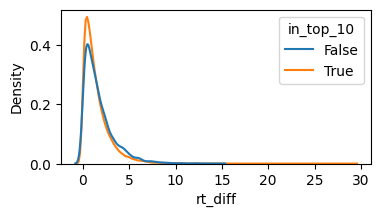

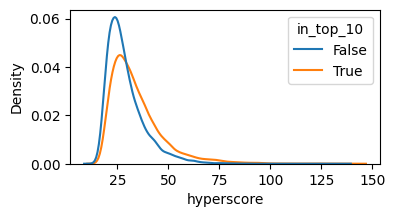

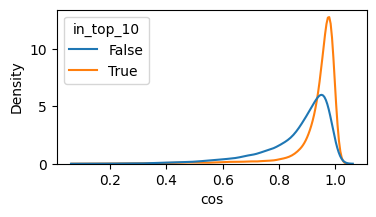

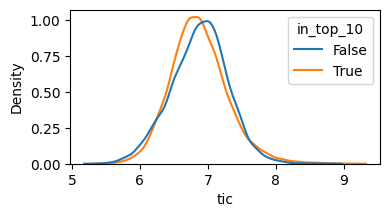

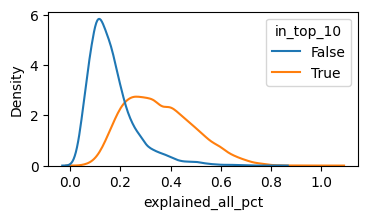

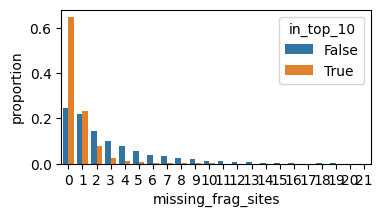

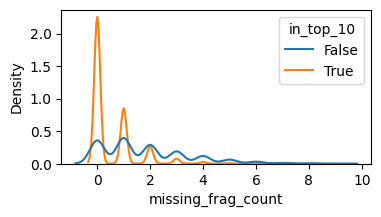

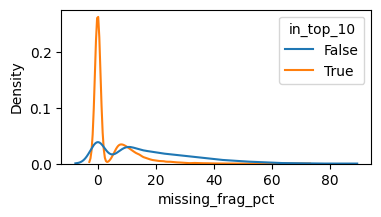

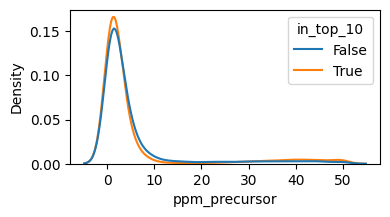

In [842]:
for i in features_of_interest:
    plt.figure(figsize=(4,2))

    if i in ['missing_frag_sites']:
        
        grouped = (
            features_casanovo_correct
            .groupby(['in_top_10', i])
            .size()
            .groupby(level=0)  # normalize within each hue group
            .apply(lambda x: x / x.sum())
            .reset_index(name='proportion')
        )

        sns.barplot(
            data=grouped,
            x=i,
            y='proportion',
            hue='in_top_10'
        )
        # sns.countplot(
        #     features_casanovo_correct,
        #     x=i,
        #     hue='in_top_10',
        #     hue_norm=True
        # )

    elif i == 'tic':
        tic_f = np.log10(features_casanovo_correct['tic'])
        sns.kdeplot(
            features_casanovo_correct,
            x=tic_f,
            hue='in_top_10',
            common_norm=False
        )

    else:
        sns.kdeplot(
            features_casanovo_correct,
            x=i,
            hue='in_top_10',
            common_norm=False   
        )

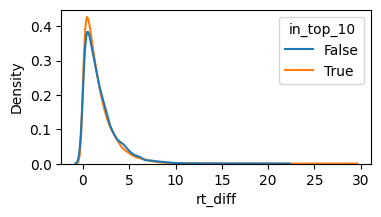

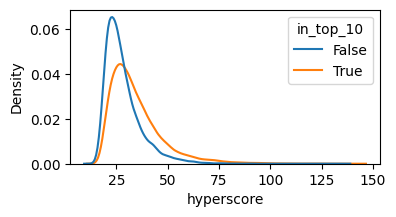

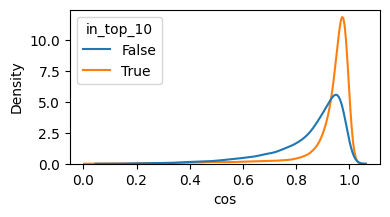

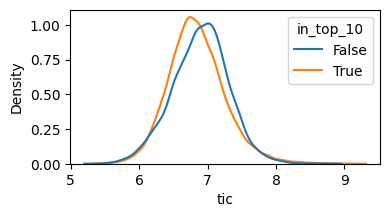

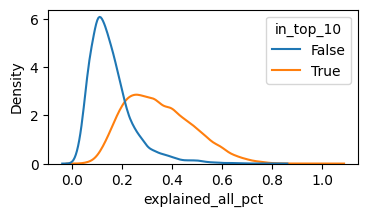

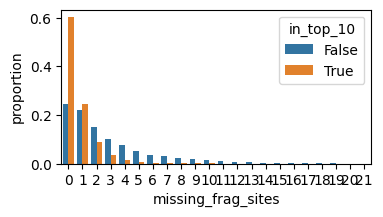

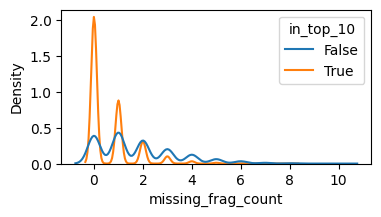

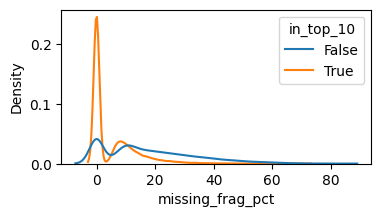

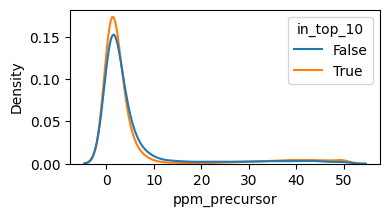

In [792]:
for i in features_of_interest:
    plt.figure(figsize=(4,2))

    if i in ['missing_frag_sites']:
        
        grouped = (
            features_casanovo_correct
            .groupby(['in_top_10', i])
            .size()
            .groupby(level=0)  # normalize within each hue group
            .apply(lambda x: x / x.sum())
            .reset_index(name='proportion')
        )

        sns.barplot(
            data=grouped,
            x=i,
            y='proportion',
            hue='in_top_10'
        )
        # sns.countplot(
        #     features_casanovo_correct,
        #     x=i,
        #     hue='in_top_10',
        #     hue_norm=True
        # )

    elif i == 'tic':
        tic_f = np.log10(features_casanovo_correct['tic'])
        sns.kdeplot(
            features_casanovo_correct,
            x=tic_f,
            hue='in_top_10',
            common_norm=False
        )

    else:
        sns.kdeplot(
            features_casanovo_correct,
            x=i,
            hue='in_top_10',
            common_norm=False   
        )

Seems like the feature that is different the most is the percentage of explained fragment ion intensity 

Check if the alternative hits are better based on some features. We have already evaluated that the second hits are most often better (92% of the cases) when we ignore the mass filter.

---

# Feature differences in Spec-absent between PSMMS2Rescore and PSMcasanovo when MS2Rescore and not Casanovo are correct

In [70]:
features_candidates = pd.read_parquet('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/casanovo.parquet')

In [78]:
features_gt = pd.read_parquet('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/ground_truth.parquet')

In [76]:
spectrum_ids_CMS2R_INCCAS = rank_isobaric_df[
    (rank_isobaric_df['casanovo']!=1) &
    (rank_isobaric_df['ms2rescore_default']==1)
].index.tolist()

features_of_interest = [
    'rt_diff',
    'hyperscore',
    'cos',
    'tic',
    'explained_all_pct',
    'missing_frag_sites',
    'missing_frag_count',
    'missing_frag_pct',
    'ppm_precursor'
]

In [77]:
features_top_candidate_not_in_top_10 = features_candidates[
    (features_candidates['rank']==1)
]
features_top_candidate_not_in_top_10 = pd.DataFrame(features_top_candidate_not_in_top_10.set_index('spectrum_id').loc[
    spectrum_ids_CMS2R_INCCAS
]['rescoring_features'].tolist())[features_of_interest]
features_top_candidate_not_in_top_10['spectrum_id'] = spectrum_ids_CMS2R_INCCAS
features_top_candidate_not_in_top_10 = features_top_candidate_not_in_top_10.set_index('spectrum_id')

In [89]:
features_gt_not_int_top_10 = features_gt[
    (features_gt['rank']==1)
]
features_gt_not_int_top_10 = pd.DataFrame(features_gt_not_int_top_10.set_index('spectrum_id').loc[
    spectrum_ids_CMS2R_INCCAS
]['rescoring_features'].tolist())[features_of_interest]
features_gt_not_int_top_10['spectrum_id'] = spectrum_ids_CMS2R_INCCAS
features_gt_not_int_top_10 = features_gt_not_int_top_10.set_index('spectrum_id')

In [90]:
# Feature GT - Feature Top candidate

feature_diff = features_gt_not_int_top_10 - features_top_candidate_not_in_top_10

In [ ]:
for i in features_of_interest:
    plt.figure(figsize=(4,2))

    if i in ['missing_frag_sites', 'rt_diff']:
        
        sns.histplot(
            data=feature_diff,
            x=i
        )
        # sns.countplot(
        #     features_casanovo_correct,
        #     x=i,
        #     hue='in_top_10',
        #     hue_norm=True
        # )

    elif i == 'tic':
        tic_f = np.log10(feature_diff['tic'])
        sns.kdeplot(
            feature_diff,
            x=tic_f
        )

    else:
        sns.kdeplot(
            feature_diff,
            x=i 
        )

/home/sam/anaconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/home/sam/anaconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


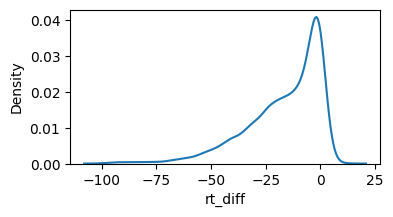

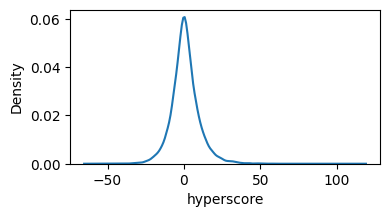

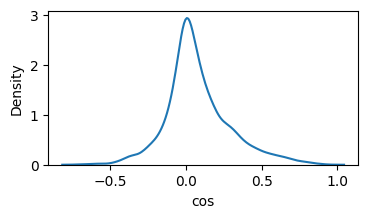

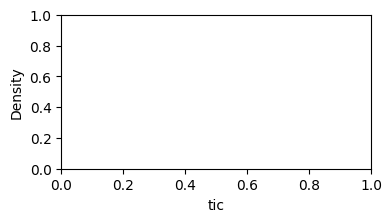

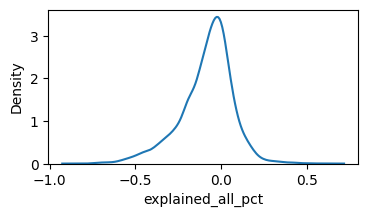

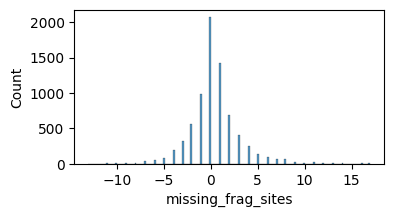

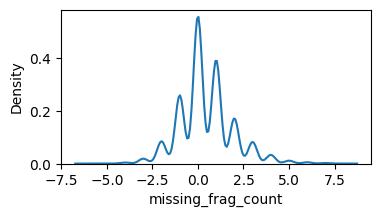

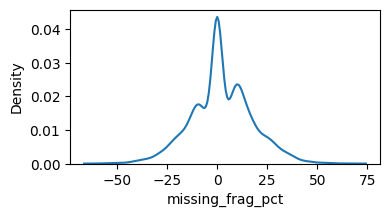

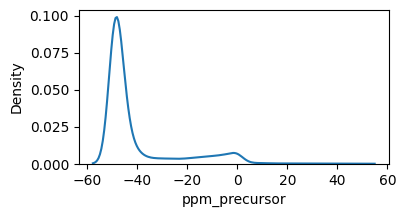

In [846]:
for i in features_of_interest:
    plt.figure(figsize=(4,2))

    if i in ['missing_frag_sites']:
        
        sns.histplot(
            data=feature_diff,
            x=i
        )
        # sns.countplot(
        #     features_casanovo_correct,
        #     x=i,
        #     hue='in_top_10',
        #     hue_norm=True
        # )

    elif i == 'tic':
        tic_f = np.log10(feature_diff['tic'])
        sns.kdeplot(
            feature_diff,
            x=tic_f
        )

    else:
        sns.kdeplot(
            feature_diff,
            x=i 
        )

/home/sam/anaconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


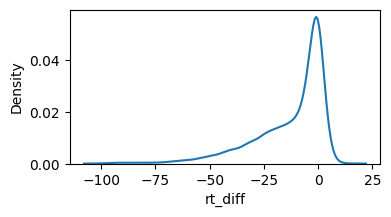

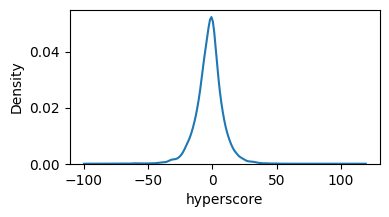

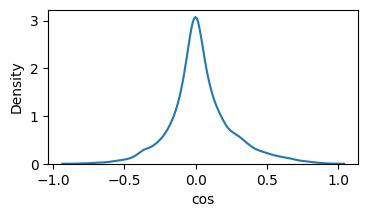

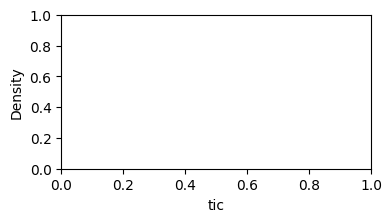

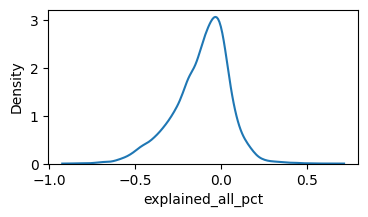

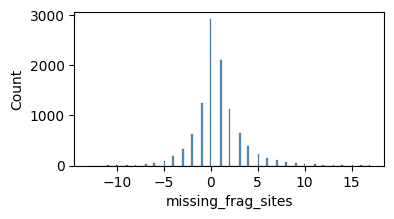

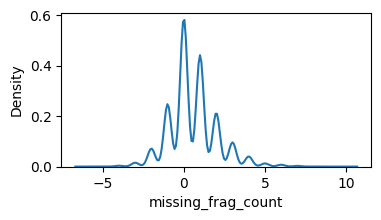

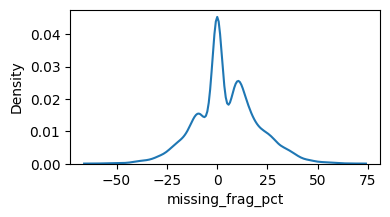

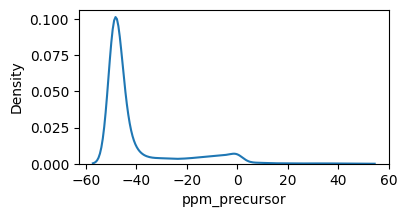

In [801]:
for i in features_of_interest:
    plt.figure(figsize=(4,2))

    if i in ['missing_frag_sites']:
        
        sns.histplot(
            data=feature_diff,
            x=i
        )
        # sns.countplot(
        #     features_casanovo_correct,
        #     x=i,
        #     hue='in_top_10',
        #     hue_norm=True
        # )

    elif i == 'tic':
        tic_f = np.log10(feature_diff['tic'])
        sns.kdeplot(
            feature_diff,
            x=tic_f
        )

    else:
        sns.kdeplot(
            feature_diff,
            x=i 
        )

In [852]:
feature_diff.sort_values('ppm_precursor')

,rt_diff,hyperscore,cos,tic,explained_all_pct,missing_frag_sites,missing_frag_count,missing_frag_pct,ppm_precursor
spectrum_id,,,,,,,,,
controllerType=0 controllerNumber=1 scan=58381,-34.186160,-2.309909,-0.053141,0.0,-0.226361,1,1,9.090909,-49.999260
controllerType=0 controllerNumber=1 scan=92564,-10.239311,-5.714606,0.703493,0.0,-0.319734,5,3,26.315789,-49.998687
controllerType=0 controllerNumber=1 scan=79407,-36.278676,-11.828482,0.007813,0.0,-0.022512,1,1,10.000000,-49.997190
controllerType=0 controllerNumber=1 scan=107141,-2.858104,-13.651666,-0.111559,0.0,-0.227041,1,1,10.000000,-49.996552
controllerType=0 controllerNumber=1 scan=67821,-1.741584,0.595477,-0.165909,0.0,0.019304,0,0,0.000000,-49.996378
...,...,...,...,...,...,...,...,...,...
controllerType=0 controllerNumber=1 scan=79267,0.461497,5.118451,0.004116,0.0,0.421152,0,0,-0.476190,38.511057
controllerType=0 controllerNumber=1 scan=111590,-3.204168,15.830004,0.358790,0.0,0.103487,-3,4,-16.770186,40.596192
controllerType=0 controllerNumber=1 scan=72822,-6.871884,19.185904,0.165781,0.0,0.048950,-3,-1,-27.272727,42.214632


In [853]:
run.get_spectrum('controllerType=0 controllerNumber=1 scan=117397')

Spectrum ID: controllerType=0 controllerNumber=1 scan=117397
Ground-truth: LLQGLQVDTLY<DE>IK/2 ({'peptide': {'sage': 2.929579734802246, 'Spectralis': -1.1795238906373495, 'casanovo': 0.889362096786499, 'ms2rescore_default': 3.876580008361519, 'ms2rescore_casanovo': 3.4154371089359183, 'ms2rescore_spectralis': 3.34188289523829, 'ms2rescore_casanovo_spectralis': 3.240827312111726, 'score_ms2rescore': 2.929579734802246}, 'aa': {}})
Candidates:
	QLEFHQFVSLSTSGGK/2 ({'peptide': {'casanovo': 0.8646380305290222, 'score_ms2rescore': 0.5036348075850581, 'Spectralis': -1.577439900516417, 'ms2rescore_default': -0.3710663549540791, 'ms2rescore_casanovo': 0.867201573111177, 'ms2rescore_spectralis': -0.6929068498858942, 'ms2rescore_casanovo_spectralis': 0.7012676426218514}, 'aa': {'casanovo': (0.92641, 0.71413, 0.92737, 0.92701, 0.92596, 0.92635, 0.92579, 0.92599, 0.90522, 0.83485, 0.92708, 0.92812, 0.45898, 0.59842, 0.92869, 0.92936, 0.9271)}})
	<Q[UNIMOD:7]L>EQHQFVSLSTSGGK/2 ({'peptide': {'casanov

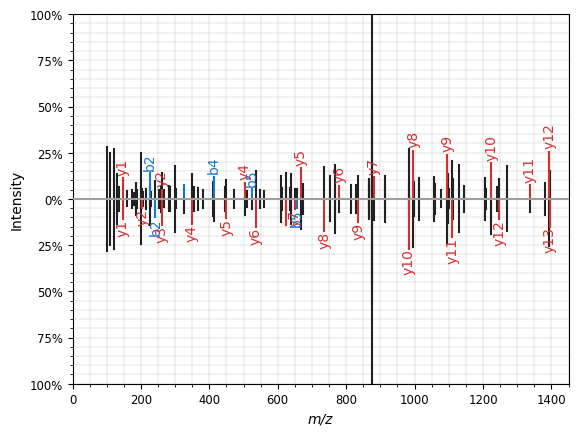

In [854]:
create_mirror(
    spectrum_id='controllerType=0 controllerNumber=1 scan=117397',
    peak_path=os.path.join(root_mgf, filenames[0]+'.mgf'),
    peptide_1='LLQGLQVDTLYDEIK',
    peptide_2='QLEFHQFVSLSTSGGK'
)

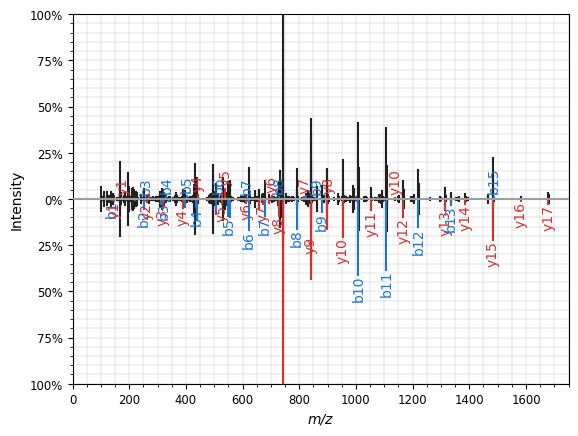

In [807]:
create_mirror(
    spectrum_id='controllerType=0 controllerNumber=1 scan=112064',
    peak_path=os.path.join(root_mgf, filenames[0]+'.mgf'),
    peptide_1='SGDAAIVDMVPGKPM[UNIMOD:35]C[UNIMOD:4]VESFSDYPPLGR',
    peptide_2='HLADLAGNSEVLLPVPAFNVLNGGSHAGNK'
)

## 3. Why does Casanovo fail for spectra it cannot predict the correct peptide for

Surprisingly, this is already apparent in a plot above: it cannot find a sequence matching the precursor mass

Maybe plot how far its off. There must be other features as well ?

In [870]:
rank_isobaric_df_false.apply(
        lambda x: x['casanovo']-x['ms2rescore_default'],
        axis=1
    ).value_counts().sort_index()

-10.0      89
-9.0      136
-8.0      179
-7.0      259
-6.0      329
-5.0      447
-4.0      497
-3.0      568
-2.0      651
-1.0      933
 0.0     8291
 1.0     2540
 2.0     1777
 3.0     1364
 4.0     1219
 5.0      972
 6.0      912
 7.0      780
 8.0      720
 9.0      657
 10.0    1813
dtype: int64

<Axes: ylabel='Count'>

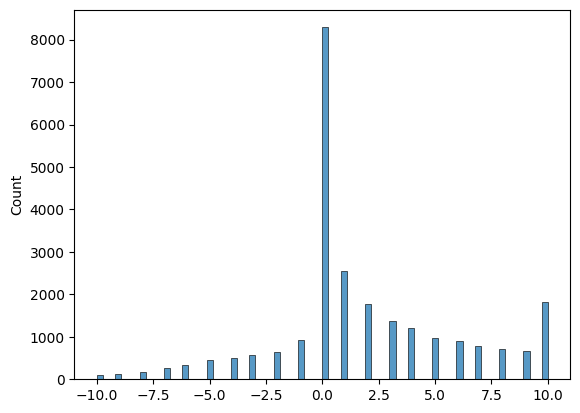

In [935]:
sns.histplot(
    rank_isobaric_df_false.apply(
        lambda x: x['casanovo']-x['ms2rescore_default'],
        axis=1
    )
)

<Axes: ylabel='Count'>

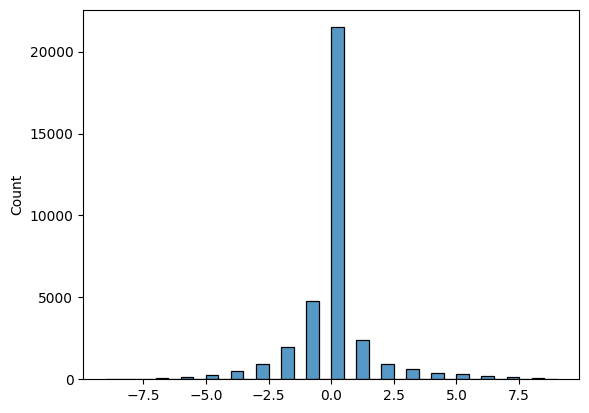

In [873]:
sns.histplot(
    rank_isobaric_df.apply(
        lambda x: x['casanovo']-x['ms2rescore_default'],
        axis=1
    ),
    binwidth=.5
)

In [876]:
rank_isobaric_df_false[
    (rank_isobaric_df_false['casanovo']==1) &
    (rank_isobaric_df_false['ms2rescore_default']==11)
]

,casanovo,Spectralis,score_ms2rescore,ms2rescore_default,ms2rescore_casanovo,ms2rescore_spectralis,ms2rescore_casanovo_spectralis,psm,InstaNovo+
controllerType=0 controllerNumber=1 scan=80079,1.0,11.0,3.0,11.0,1.0,11.0,1.0,"{'peptidoform': Peptidoform('ISADYPIITGQR/2'),...",2.0
controllerType=0 controllerNumber=1 scan=102072,1.0,1.0,10.0,11.0,1.0,9.0,1.0,{'peptidoform': Peptidoform('AGDTVIPIYIPQC[UNI...,1.0
controllerType=0 controllerNumber=1 scan=129651,1.0,1.0,11.0,11.0,1.0,1.0,1.0,{'peptidoform': Peptidoform('AEPPQC[UNIMOD:4]T...,-1.0
controllerType=0 controllerNumber=1 scan=121359,1.0,4.0,11.0,11.0,1.0,10.0,1.0,{'peptidoform': Peptidoform('IVQNGTEPSSIPFIDPN...,-1.0
controllerType=0 controllerNumber=1 scan=45776,1.0,3.0,10.0,11.0,1.0,9.0,1.0,{'peptidoform': Peptidoform('EGFITHGDDEDDEASAP...,5.0
...,...,...,...,...,...,...,...,...,...
controllerType=0 controllerNumber=1 scan=30506,1.0,11.0,11.0,11.0,1.0,11.0,1.0,{'peptidoform': Peptidoform('IAGYTTHIM[UNIMOD:...,-1.0
controllerType=0 controllerNumber=1 scan=118772,1.0,10.0,1.0,11.0,1.0,10.0,1.0,{'peptidoform': Peptidoform('QAGIGGEIIC[UNIMOD...,-1.0
controllerType=0 controllerNumber=1 scan=73929,1.0,10.0,11.0,11.0,1.0,11.0,1.0,{'peptidoform': Peptidoform('HMSEFM[UNIMOD:35]...,4.0
controllerType=0 controllerNumber=1 scan=123291,1.0,11.0,3.0,11.0,1.0,11.0,1.0,{'peptidoform': Peptidoform('EMDVVQYAKGIIDDPTF...,-1.0


In [877]:
run.get_spectrum('controllerType=0 controllerNumber=1 scan=80079')

Spectrum ID: controllerType=0 controllerNumber=1 scan=80079
Ground-truth: LSADYPLLT<GQ>R/2 ({'peptide': {'sage': 3.8312318325042725, 'Spectralis': -1.5989228866326637, 'InstaNovo+': -0.0850002318620681, 'casanovo': 0.7196207046508789, 'ms2rescore_default': 3.6051406346703296, 'ms2rescore_casanovo': 3.028729653208394, 'ms2rescore_spectralis': 2.4047800210942345, 'ms2rescore_casanovo_spectralis': 2.576276748340109, 'score_ms2rescore': 3.8312318325042725}, 'aa': {}})
Candidates:
	LEFPMP<NE>EAR/2 ({'peptide': {'casanovo': -0.05299801751971245, 'score_ms2rescore': 3.582419277023831, 'Spectralis': -0.2218252769682651, 'ms2rescore_default': 4.287289827431571, 'ms2rescore_casanovo': -0.0734869145389706, 'ms2rescore_spectralis': 4.955873206071179, 'ms2rescore_casanovo_spectralis': 1.04971050176501}, 'aa': {'casanovo': (0.96135, 0.88367, 0.96123, 0.85682, 0.96717, 0.96899, 0.9269, 0.96848, 0.96885, 0.96479, 0.96709)}})
	LEFPMPENEAR/2 ({'peptide': {'casanovo': -0.10864812880754471, 'score_ms2resc